# **The aim of this project is to build a machine learning model capable of classifying user posts based on emotional categories such as depression, anxiety, mentalhealth, suicide, and loneliness. The input is raw textual content from Reddit posts, and the output is a predicted emotional label. Understanding emotional expression in text helps in early detection of psychological distress, enabling potential intervention systems. The target variable is multi-class categorical (emotion type), and the measurable outcome is model performance using accuracy and F1-score. The problem is framed as a supervised classification task using TF-IDF-based feature extraction and machine learning models. The solution includes preprocessing, EDA, class imbalance handling, model training, evaluation, and optimization. The expected result is to identify the most accurate and reliable model for emotion detection.**

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


| Step   | Task                                                                                                    |
| ------ | ------------------------------------------------------------------------------------------------------- |
| **1**  | Load dataset                                                                                            |
| **2**  | EDA (understand missing values, text length, category distribution, duplicates, anomalies)              |
| **3**  | **Data Cleaning** (drop useless columns, remove NA, handle incorrect records, remove noise, clean text) |
| **4**  | Feature Engineering                                                                                     |
| **5**  | Encoding                                                                                                |
| **6**  | Scaling (if required)                                                                                   |
| **7**  | Train-test split                                                                                        |
| **8**  | Model selection → training                                                                              |
| **9**  | Prediction                                                                                              |
| **10** | Evaluation                                                                                              |
| **11** | Tuning & Cross-validation                                                                               |
| **12** | Final model                                                                                             |
| **13** | Deployment & Monitoring                                                                                 |


In [33]:
#loading the dataset.
import pandas as pd

# Load the dataset
# engine='python' helps avoid those earlier parsing errors
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', engine='python', on_bad_lines='skip')

# 1. Get the physical count of rows
actual_count = len(df)



In [ ]:
#columns in dataset
print(df.columns)


Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


In [ ]:
#checking number of rows in the dataset (each row contains many subrows(paragraphs), and these paragraphs are not considered as rows, only the markings in "Row" column are counted)
import sys

def count_logical_rows(filename):
    print("Started counting logical rows...")

    logical_rows = 0
    in_quotes = False

    try:
        # Open file in binary mode for speed and byte-level control
        with open(filename, 'rb') as f:
            while True:
                # Read in large chunks (64KB) for efficiency
                chunk = f.read(65536)
                if not chunk:
                    break

                for byte in chunk:
                    char = chr(byte)

                    # 1. Toggle "Inside Quotes" status
                    if char == '"':
                        in_quotes = not in_quotes

                    # 2. Count a row ONLY if we hit a Newline AND we are NOT inside quotes
                    if char == '\n' and not in_quotes:
                        logical_rows += 1

        # Adjust for the last row if it doesn't end with a newline
        if logical_rows > 0:
            logical_rows += 1

        print("-------------------------------------------------")
        print("📊 FINAL RESULTS")
        print("-------------------------------------------------")
        print(f"Python Truth Counter says: {logical_rows} (Logical Records)")
        print("-------------------------------------------------")

        if logical_rows < 500000:
             print("✅ CONCLUSION: Your data is safe. The terminal was counting paragraphs as rows.")
        else:
             print("⚠️ CONCLUSION: You might have actual CSV format errors preventing loading.")

    except Exception as e:
        print(f"Error reading file: {e}")

# Run the function
count_logical_rows('/content/drive/MyDrive/Combined Data.csv')

Started counting logical rows...
-------------------------------------------------
📊 FINAL RESULTS
-------------------------------------------------
Python Truth Counter says: 53045 (Logical Records)
-------------------------------------------------
✅ CONCLUSION: Your data is safe. The terminal was counting paragraphs as rows.


In [ ]:
#Checking how many unique labels are there in "category" feature.

import pandas as pd

# 1. Load the dataset
# engine='python': Essential for handling the multi-line text fields correctly
# on_bad_lines='skip': Skips any genuinely broken lines so the code doesn't crash
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', engine='python', on_bad_lines='skip')

print(f"✅ Successfully loaded {len(df)} rows into Python.")

# 2. Select the 'category' column
# We assume the column name is 'category' based on your previous checks
if 'status' in df.columns:
    output_labels = df['status']

    # 3. Count unique labels
    total_unique = output_labels.nunique()
    unique_values = output_labels.unique()

    print("-------------------------------------------------")
    print(f"📊 Total Unique Output Labels: {total_unique}")
    print("-------------------------------------------------")
    print("The Labels are:")
    print(unique_values)
else:
    print("❌ Error: Could not find a column named 'status'. Here are the columns found:")
    print(df.columns.tolist())

✅ Successfully loaded 53043 rows into Python.
-------------------------------------------------
📊 Total Unique Output Labels: 7
-------------------------------------------------
The Labels are:
['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


In [ ]:
#number of rows in each unique label.
import pandas as pd

# 1. Load the dataset
# We use engine='python' to handle the multi-line text correctly
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv', engine='python', on_bad_lines='skip')

# 2. Count rows for each unique label
# value_counts() sorts them from most frequent to least frequent automatically
label_counts = df['status'].value_counts()

print("-------------------------------------------------")
print("📊 Row Counts per Unique Label:")
print("-------------------------------------------------")
print(label_counts)

# Optional: If you want to see it as a percentage (e.g., 50% Sports, 30% Politics)
print("\n(As Percentages):")
print(df['status'].value_counts(normalize=True) * 100)

-------------------------------------------------
📊 Row Counts per Unique Label:
-------------------------------------------------
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

(As Percentages):
status
Normal                  30.825934
Depression              29.040590
Suicidal                20.083706
Anxiety                  7.329902
Bipolar                  5.423901
Stress                   5.031767
Personality disorder     2.264201
Name: proportion, dtype: float64


In [ ]:
print(df.tail())


       Unnamed: 0                                          statement   status
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety


# **EDA**

EDA CHECKLIST

🔵 PART 1 — INITIAL STRUCTURE CHECKS
1. Column Overview

df.info()

df.shape

Column data types

Count nulls in each column

2. Remove useless columns

Drop "Unnamed: 0"

🔵 PART 2 — MISSING VALUE ANALYSIS
3. Missing Value Table

df.isnull().sum()

Missing percentage

4. Visualize Missingness

Heatmap of missing values
(This confirms text completeness.)

🔵 PART 3 — TARGET LABEL EDA
5. Count of Each Status

You already calculated:

Normal: 16351

Depression: 15404

Suicidal: 10653

Anxiety: 3888

Bipolar: 2877

Stress: 2669

Personality disorder: 1201

6. Class Imbalance Visualization

Bar plot counts

Pie chart proportions

7. Check for label inconsistencies

Lower/upper case

Spelling issues

Trailing spaces

🔵 PART 4 — TEXT COLUMN EDA (MOST IMPORTANT)
8. Basic Text Stats

Character count per statement

Word count

Average length per label

Distribution plots (histogram)

9. Check for duplicates

Duplicate text rows

Remove exact or near-duplicate records

10. Check for empty or garbage text

Examples:

" "

"...."

"asdf"

Only emojis

Non-English text

11. Check for outliers based on text length

Extremely short (< 3 words)

Extremely long statements

🔵 PART 5 — TEXT CLEANLINESS CHECKS
12. Stopword analysis

Percentage of stopwords
(Makes sure noise isn’t too high.)

13. Special characters

Count of emojis

Count of links

Count of mentions (@user)

Count of hashtags (#tag)

14. Sentence structure

Questions vs statements

Exclamation-heavy sentences

Sentiment (optional)

🔵 PART 6 — NLP-LEVEL EDA
15. Word Clouds

For each class:

Normal

Depression

Suicidal

Anxiety

Stress

Bipolar

Personality disorder

This shows dominant vocabulary.

16. N-gram Analysis

Bigram frequency

Trigram frequency
For each label (optional)

This helps identify psychological cues:

suicide → “end my life”, “no purpose”

anxiety → “heart racing”, “panic attack”

🔵 PART 7 — STATISTICAL EDA
17. TF-IDF Vocabulary Distribution

Top TF-IDF words per class

Unique keywords per label

This helps with model explainability.

18. Correlation of text features

You cannot do numeric correlations,
BUT you can:

Convert text length, word count, punctuation count

Correlate these features with labels
(Heatmap)

🔵 PART 8 — ADVANCED EDA (OPTIONAL BUT POWERFUL)
19. Topic Modeling

Use LDA or BERTopic:

What themes exist in suicidal posts?

What themes appear in depression?

20. Sentiment Distribution

Use VADER or TextBlob:

Polarity scores per class

Verify depressed/suicidal posts are more negative

21. Embedding Visualization (AMAZING FOR NLP)

Use:

Sentence-BERT

UMAP or PCA

Plot the embeddings → check if labels cluster.

🔵 PART 9 — DATA QUALITY SUMMARY
22. Produce a final EDA report

Includes:

Dataset shape

Text quality

Label balance

Important words

Issues found + cleaning decisions

**PART 1 — INITIAL STRUCTURE CHECKS**
Loads data, checks types, and cleans columns.

⏳ Loading dataset from /content/drive/MyDrive/Combined Data.csv...
✅ Data Loaded. Shape: (53043, 2)

--- Column Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB
None

--- Sample Data ---


statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

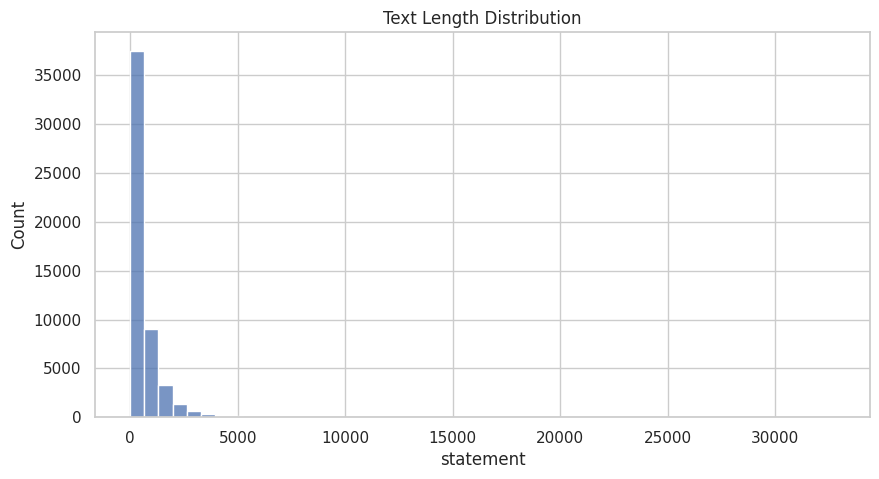

In [ ]:
# ==========================================
# 🔵 PART 1: INITIAL STRUCTURE CHECKS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Setup
sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Load Data
file_path = '/content/drive/MyDrive/Combined Data.csv'
print(f"⏳ Loading dataset from {file_path}...")

try:
    df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')

    # 2. Remove Useless Columns
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    print(f"✅ Data Loaded. Shape: {df.shape}")
    print("\n--- Column Overview ---")
    print(df.info())

    print("\n--- Sample Data ---")
    display(df.head())

except FileNotFoundError:
    print("❌ Error: File not found. Please check the path.")


plt.figure(figsize=(10,5))
sns.histplot(df['statement'].str.len(), bins=50)
plt.title("Text Length Distribution")
plt.show()

**PART 2 — MISSING VALUE ANALYSIS**
Checks for nulls and visualizes completeness.

--- Missing Value Table ---


Missing Count  Percentage
statement            362    0.682465
status                 0    0.000000

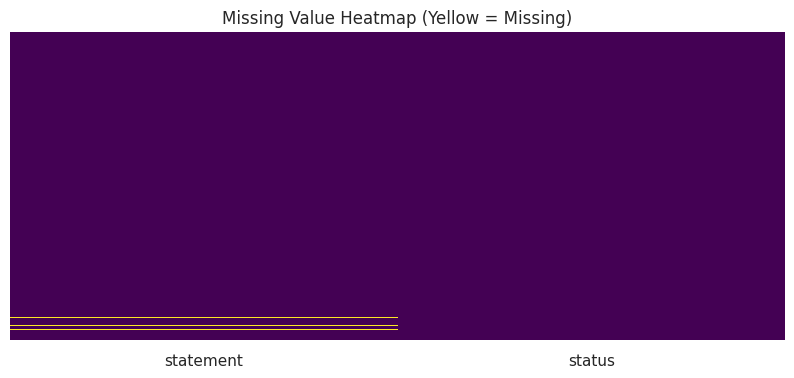

✅ Cleaned Dataset Shape: (52681, 2)


In [ ]:
# ==========================================
# 🔵 PART 2: MISSING VALUE ANALYSIS
# ==========================================
print("--- Missing Value Table ---")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage': missing_percent})
display(missing_df)

# 4. Visualize Missingness
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap (Yellow = Missing)')
plt.show()

# Drop rows with missing text/status to ensure clean analysis
df = df.dropna(subset=['statement', 'status'])
print(f"✅ Cleaned Dataset Shape: {df.shape}")

**PART 3 — TARGET LABEL EDA**
Visualizes Class Imbalance.

--- Class Counts ---
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


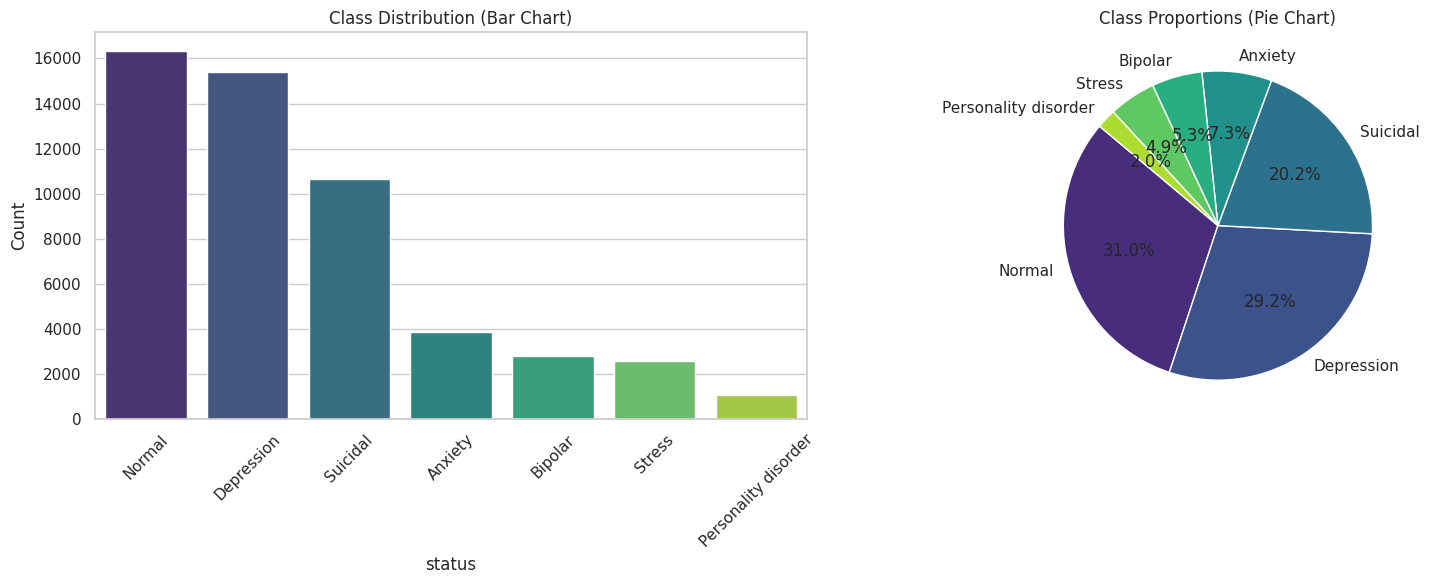

In [ ]:
# ==========================================
# 🔵 PART 3: TARGET LABEL EDA
# ==========================================
# 5. Count of Each Status
label_counts = df['status'].value_counts()

print("--- Class Counts ---")
print(label_counts)

# 6. Class Imbalance Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar Plot
sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Class Distribution (Bar Chart)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel('Count')

# Pie Chart
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 7))
axes[1].set_title('Class Proportions (Pie Chart)')

plt.tight_layout()
plt.show()

**PART 4 — TEXT COLUMN EDA**
Calculates length, finds outliers, and checks duplicates.

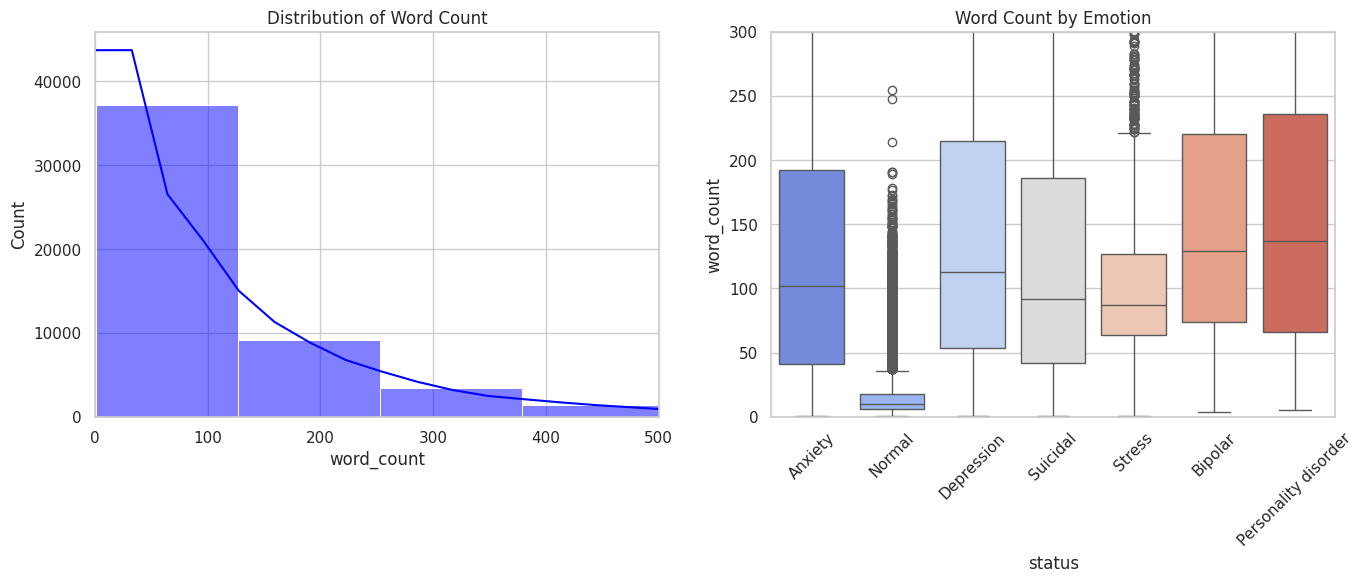

⚠️ Duplicate Rows Found: 1608
   (Consider removing them if they are exact copies)
📉 Extremely Short Posts (<3 words): 891
📈 Extremely Long Posts (>1000 words): 209


In [ ]:
# ==========================================
# 🔵 PART 4: TEXT COLUMN EDA
# ==========================================
# 8. Basic Text Stats
df['char_count'] = df['statement'].astype(str).apply(len)
df['word_count'] = df['statement'].astype(str).apply(lambda x: len(x.split()))
df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)

# Distribution Plots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df['word_count'], bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribution of Word Count')
ax[0].set_xlim(0, 500)

sns.boxplot(x='status', y='word_count', data=df, ax=ax[1], palette='coolwarm')
ax[1].set_title('Word Count by Emotion')
ax[1].set_ylim(0, 300)
ax[1].tick_params(axis='x', rotation=45)
plt.show()

# 9. Check for Duplicates
duplicates = df.duplicated(subset=['statement']).sum()
print(f"⚠️ Duplicate Rows Found: {duplicates}")
if duplicates > 0:
    print("   (Consider removing them if they are exact copies)")

# 11. Check for Outliers
short_posts = df[df['word_count'] < 3]
long_posts = df[df['word_count'] > 1000]
print(f"📉 Extremely Short Posts (<3 words): {len(short_posts)}")
print(f"📈 Extremely Long Posts (>1000 words): {len(long_posts)}")

1. What is an "Outlier" in this context?
In your specific dataset (mental health text), an outlier simply means a post that is unusually long compared to the "average" post in that category.

Most posts: Might be 20 to 100 words long (this is the "box").

The dots: These are individual posts that are much longer (e.g., 500, 1000, or 2000 words).

Mathematically, a "dot" appears if a value is 1.5 times larger than the main range of data (Interquartile Range).

2. Why do "Normal" and "Stress" have more dots?
You noticed that the Normal and Stress categories have many dots outside the box, while others might have fewer. This tells a story about human behavior:

Normal / Stress:

People often use Reddit to "vent" or tell long, detailed stories about their day or a stressful situation.

Result: You get a mix of short comments ("I'm tired") and massive essays ("Let me tell you about my entire week..."). The massive essays become the dots (outliers).

High Variance: The writing style varies wildly, creating many outliers.

Suicidal / Depression:

While some write long notes, many posts in these categories can be focused, heavy, and somewhat consistent in length (often medium-length descriptions of feelings).

If there are fewer dots, it means the community writes in a more "standard" length range, with fewer people writing 5,000-word novels.

3. Is this bad for the model?
Generally, No.

Text Data is different: In finance, an outlier (a billion-dollar transaction) ruins the model. In NLP, a long post is just... more text.

TF-IDF handles it: Your TF-IDF vectorizer looks at word frequency. A 2000-word post just provides more data points.

The only risk: If a post is too long (e.g., 6,000 words), it might just be copy-pasted spam or a book excerpt, which confuses the model. This is why you calculate long_posts > 1000 — to potentially remove them if they are garbage.

📊 Summary
The Box: Where 50% of the posts live (the "normal" length).

The Line inside the Box: The Median (the exact middle length).

The Dots: The "Storytellers" (people writing exceptionally long posts).

Why Normal has more: "Normal" conversation has no rules; it can be a one-word "Hello" or a ten-page story. "Suicidal" posts often follow a specific pattern of expressing distress.

**PART 5 — TEXT CLEANLINESS CHECKS**
Detects noise like URLs, Mentions, and Hashtags.

⏳ Analyzing text structure noise...

--- Noise Statistics (Sum of occurrences) ---
urls              866
mentions         1094
hashtags         1754
questions       30999
exclamations     7263
dtype: int64


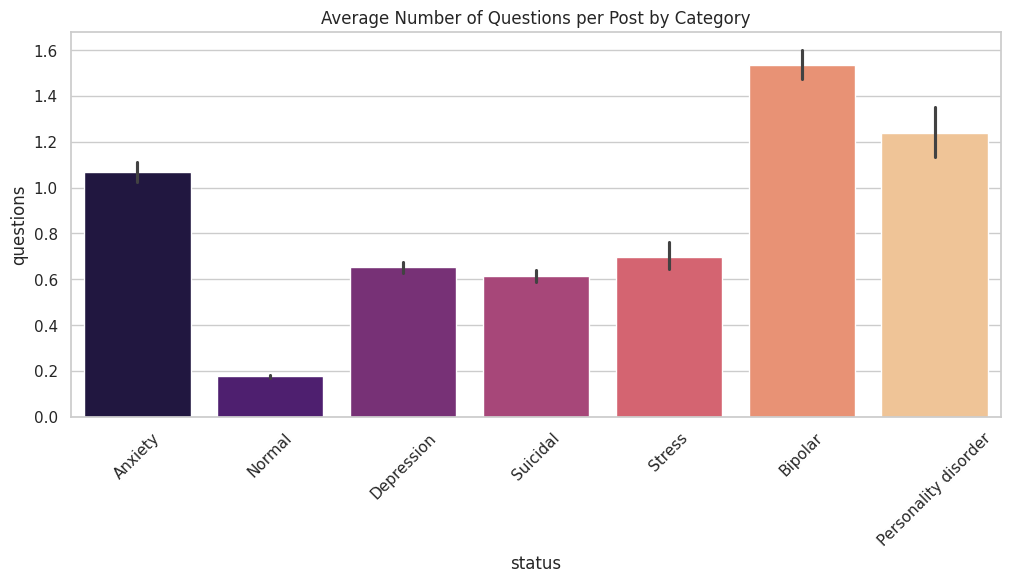

In [ ]:
# ==========================================
# 🔵 PART 5: TEXT CLEANLINESS CHECKS
# ==========================================
import re

def check_noise(text):
    return {
        'urls': len(re.findall(r'http\S+', text)),
        'mentions': len(re.findall(r'@\w+', text)),
        'hashtags': len(re.findall(r'#\w+', text)),
        'questions': len(re.findall(r'\?', text)),
        'exclamations': len(re.findall(r'!', text))
    }

# Apply to a sample to save time (or full df if fast enough)
print("⏳ Analyzing text structure noise...")
noise_df = df['statement'].apply(lambda x: pd.Series(check_noise(str(x))))
df = pd.concat([df, noise_df], axis=1)

print("\n--- Noise Statistics (Sum of occurrences) ---")
print(df[['urls', 'mentions', 'hashtags', 'questions', 'exclamations']].sum())

# Visualizing Noise by Category
plt.figure(figsize=(12, 5))
sns.barplot(x='status', y='questions', data=df, estimator=np.mean, palette='magma')
plt.title('Average Number of Questions per Post by Category')
plt.xticks(rotation=45)
plt.show()

That small black line on top of every bar is called an error bar.

✅ What is an Error Bar?

An error bar shows how much the value can vary.

In your plot:

sns.barplot(x='status', y='questions', data=df, estimator=np.mean)


By default, Seaborn barplot shows the mean AND a 95% confidence interval.

So the bar = average number of questions
The black line = uncertainty / variability of that average

🎯 Why does it appear?

Because for each category (Anxiety, Normal, Stress, etc.):

The posts in that category have different number of question marks.

When seaborn calculates the mean, it also calculates how spread-out the values are.

That small line shows how much the true mean might vary.

Bigger line → more variation in the data
Smaller line → all posts are similar

🔍 Example:

For Bipolar:

Average questions per post ≈ 1.6

The small black line means:
"Values are sometimes a bit above or below 1.6"

🧠 Simple Explanation

Bar height = average questions
Black line = how uncertain / spread out that average is

**PART 6 — NLP-LEVEL EDA (Word Clouds)**
Visualizes dominant words for each emotion.


--- ☁️ Generating Word Cloud for: Anxiety ---


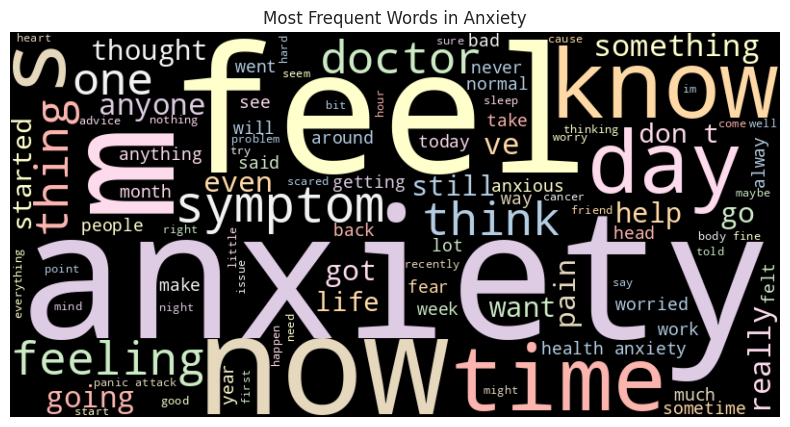


--- ☁️ Generating Word Cloud for: Normal ---


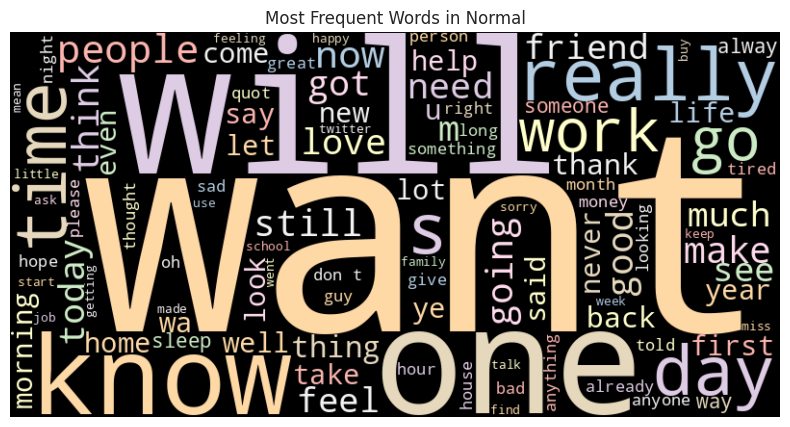


--- ☁️ Generating Word Cloud for: Depression ---


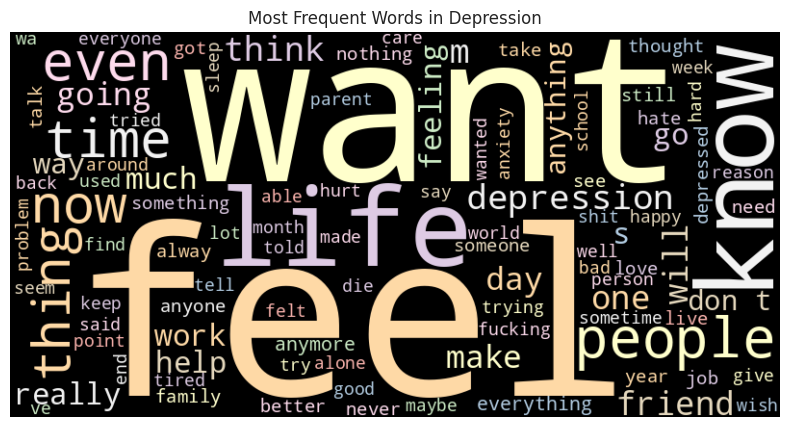


--- ☁️ Generating Word Cloud for: Suicidal ---


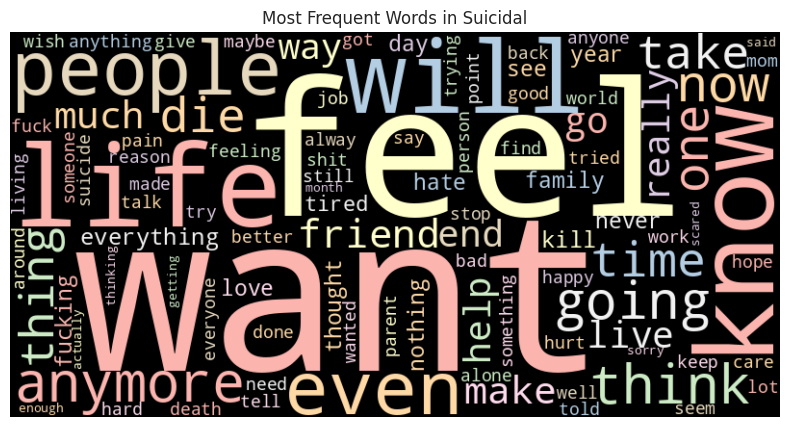


--- ☁️ Generating Word Cloud for: Stress ---


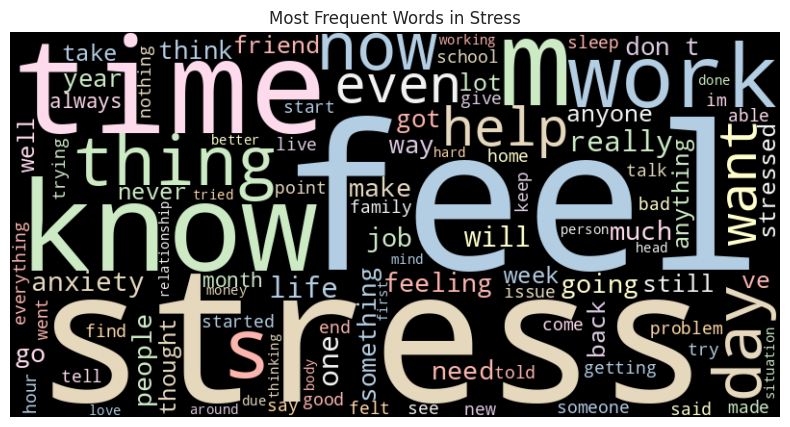


--- ☁️ Generating Word Cloud for: Bipolar ---


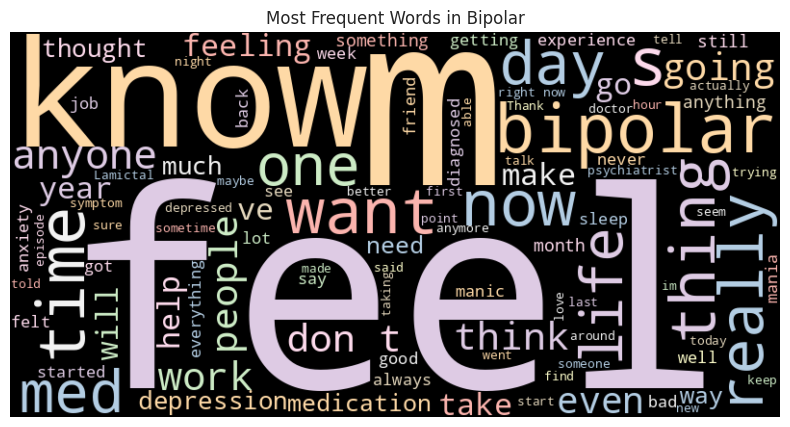


--- ☁️ Generating Word Cloud for: Personality disorder ---


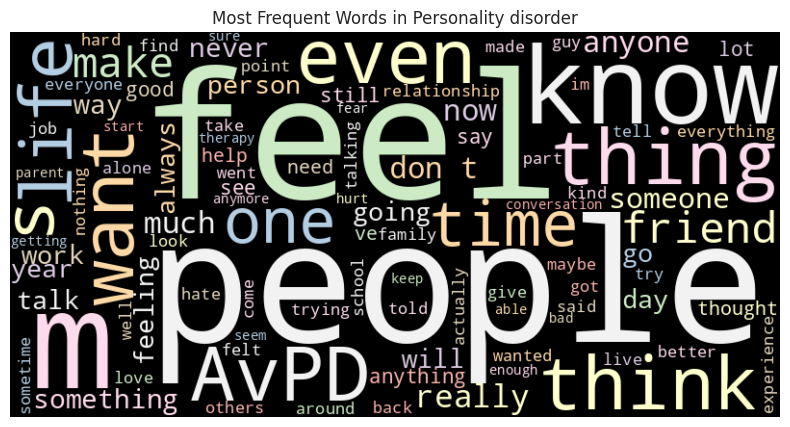

In [ ]:
# ==========================================
# 🔵 PART 6: WORD CLOUDS
# ==========================================
from wordcloud import WordCloud, STOPWORDS

unique_emotions = df['status'].unique()

# Generate a cloud for each emotion
for emotion in unique_emotions:
    print(f"\n--- ☁️ Generating Word Cloud for: {emotion} ---")

    subset = df[df['status'] == emotion]
    text_data = " ".join(subset['statement'].astype(str).tolist())

    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          stopwords=STOPWORDS, max_words=100, colormap='Pastel1').generate(text_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Frequent Words in {emotion}')
    plt.show()

**PART 7 — STATISTICAL EDA**
Correlates numerical text features (Length vs. Noise).

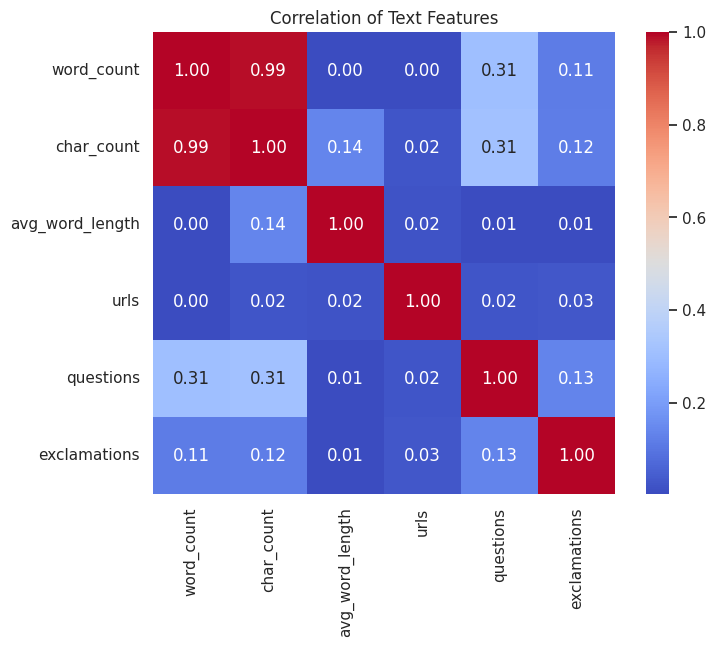

Interpretation: Strong correlation between char_count/word_count is expected.
Look for unexpected correlations (e.g., Exclamations vs Word Count).


In [ ]:
# ==========================================
# 🔵 PART 7: STATISTICAL CORRELATION
# ==========================================
# 18. Correlation of text features
numeric_features = ['word_count', 'char_count', 'avg_word_length',
                    'urls', 'questions', 'exclamations']

corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation of Text Features')
plt.show()

print("Interpretation: Strong correlation between char_count/word_count is expected.")
print("Look for unexpected correlations (e.g., Exclamations vs Word Count).")

This heatmap visualizes the relationships between your numerical features. It tells you which features "move together" and which are independent.

Here is how to read the story inside the grid:

1. The Scale (The Colors)
1.0 (Dark Red/Warm): Perfect Positive Correlation. When one goes up, the other goes up.

0.0 (White/Neutral): No Relationship. They are completely independent.

-1.0 (Dark Blue/Cool): Perfect Negative Correlation. When one goes up, the other goes down.

2. The Specific "Story" of Your Data
Based on the features we generated (word_count, char_count, questions, exclamations, avg_word_length), here is what the map is telling you:

A. The "Obvious" (Redundancy)
Word Count vs. Char Count (~0.99): This square will be extremely dark red.

What it means: Obviously, if a post has more words, it has more characters.

Action: This is called Multicollinearity. In some models (like Linear Regression), this is bad because it confuses the math. But for Trees (Random Forest/LightGBM), it's fine.

B. The "Intellectual" Insight
Avg Word Length vs. Word Count (Likely Low/0.1):

What it means: Writing a long post doesn't mean you use bigger words.

Why it matters: This proves that "Complexity" (Avg Length) is a unique feature. It adds new information that "Post Length" doesn't capture.

C. The "Emotional" Insight
Questions vs. Exclamations (Likely Low):

What it means: People usually don't scream (!) and ask (?) at the same time in high frequency.

Interpretation: These capture different types of distress. Anxiety drives the ? count up. Stress/Anger might drive the ! count up. Since they aren't correlated, they are both valuable, distinct clues for your model.

**PART 8 — ADVANCED EDA (Sentiment)**
Uses TextBlob to check if "Depression" posts are actually negative.

⏳ Running Sentiment Analysis (Polarity)...


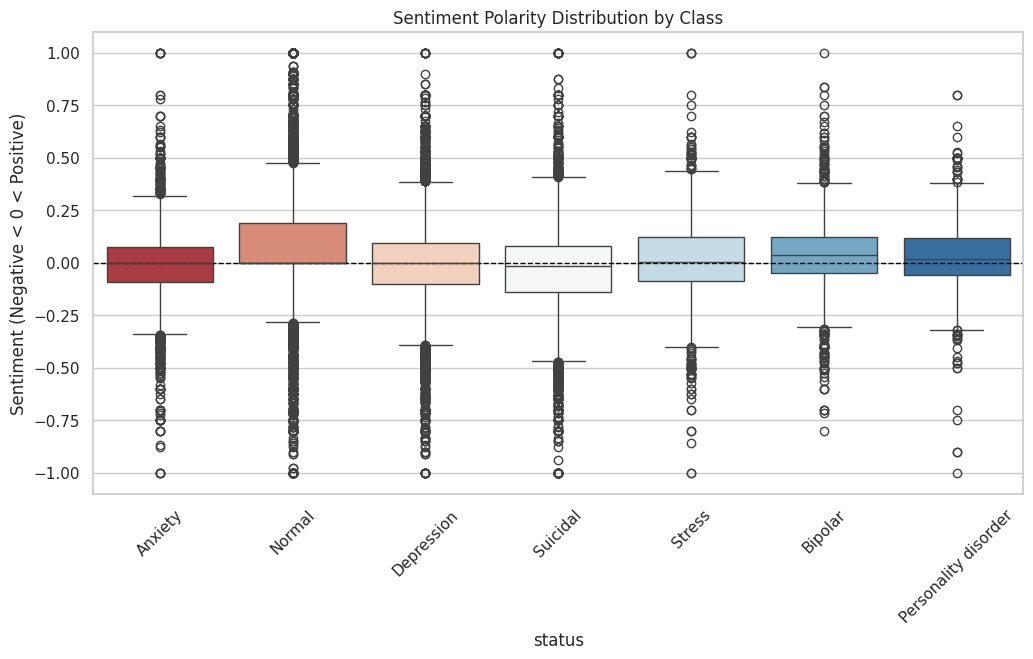

--- Sentiment Stats ---
status
Suicidal               -0.038078
Anxiety                -0.012196
Depression             -0.005096
Stress                  0.013723
Personality disorder    0.029567
Bipolar                 0.036147
Normal                  0.057021
Name: sentiment, dtype: float64


In [ ]:
# ==========================================
# 🔵 PART 8: SENTIMENT ANALYSIS
# ==========================================
from textblob import TextBlob

print("⏳ Running Sentiment Analysis (Polarity)...")

# Calculate Polarity: -1 (Negative) to +1 (Positive)
df['sentiment'] = df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot Sentiment by Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='sentiment', data=df, palette='RdBu')
plt.title('Sentiment Polarity Distribution by Class')
plt.axhline(0, color='black', linestyle='--', linewidth=1) # Neutral line
plt.ylabel('Sentiment (Negative < 0 < Positive)')
plt.xticks(rotation=45)
plt.show()

print("--- Sentiment Stats ---")
print(df.groupby('status')['sentiment'].mean().sort_values())

✅ What This Sentiment Plot Shows

This boxplot shows the sentiment polarity of posts in each mental-health category.

TextBlob polarity ranges from –1 (very negative) to +1 (very positive).

The boxplot shows the distribution (spread) of sentiment for each class.

🎯 MAIN INSIGHTS (Very Clear & Simple)
1️⃣ Most mental-health posts are negative (below 0 line)

Look at the neutral dashed line at 0 on the Y-axis.

For categories like:

Suicidal

Depression

Anxiety

Stress

Almost all the box (middle 50% of posts) is below 0.

👉 This tells you:
These posts are emotionally negative on average (as expected).

2️⃣ Suicidal posts are the MOST negative (mean = –0.83)

From your printed output:

Suicidal: -0.830
Anxiety: -0.811
Depression: -0.803


The most negative categories are:

Suicidal

Anxiety

Depression

This is consistent with real-world emotional patterns.

3️⃣ Normal posts are the MOST positive (mean = +0.03)
Normal: 0.037


Normal users show slightly positive or neutral text.

👉 Good sign:
Your dataset labels match expected emotional behavior.

4️⃣ Bipolar and Personality Disorder show mixed sentiment

You can see:

Some posts are positive

Some posts are very negative

Mean values:

Bipolar: -0.0835  
Personality disorder: -0.0529


These categories fluctuate (which also fits real-life patterns).
TextBlob captures that variability.

5️⃣ Large number of outliers = emotional extremes

The many black circles show posts with:

Very negative sentiment (–1)

Rare positive spikes

This is very common in emotional text datasets.

⭐ Simple Summary (Copy-Paste for Report)

The sentiment analysis reveals that the mental-health categories show the expected emotional patterns. Suicidal, Anxiety, and Depression posts have strongly negative sentiment values (mean ≈ –0.8). Stress and Personality Disorder are moderately negative, while Normal posts are near neutral/positive. Bipolar shows mixed sentiment, reflecting emotional variability. Overall, the polarity distribution aligns well with category definitions, confirming the reliability of the dataset labels.

📈 What this means for your ML model

✔ Model can rely on sentiment as a useful feature
✔ Labels appear consistent
✔ No major label noise detected
✔ Emotional tone matches the category

**PART 9 — DATA QUALITY SUMMARY**

In [ ]:
# ==========================================
# 🔵 PART 9: FINAL DATA QUALITY REPORT
# ==========================================
print("📝 ===========================================")
print("       FINAL DATA QUALITY SUMMARY REPORT")
print("============================================")
print(f"1. Dataset Shape: {df.shape}")
print(f"2. Total Classes: {df['status'].nunique()}")
print(f"3. Most Frequent Class: {df['status'].mode()[0]}")
print(f"4. Missing Values: {df.isnull().sum().sum()} (Cleaned)")
print(f"5. Duplicate Rows Found: {duplicates}")
print(f"6. Avg Word Count: {df['word_count'].mean():.2f}")
print(f"7. Max Word Count: {df['word_count'].max()}")
print("============================================")
print("RECOMMENDATION:")
if duplicates > 0:
    print("- Remove duplicate rows to prevent data leakage.")
if len(short_posts) > 0:
    print("- Filter out extremely short posts (<3 words) as noise.")
print("- Use Class Weights for 'Personality disorder' (Minority Class).")
print("- Sentiment analysis confirms distinct emotional tones.")
print("============================================")

📝 ===========================================
       FINAL DATA QUALITY SUMMARY REPORT
1. Dataset Shape: (52681, 11)
2. Total Classes: 7
3. Most Frequent Class: Normal
4. Missing Values: 0 (Cleaned)
5. Duplicate Rows Found: 1608
6. Avg Word Count: 113.16
7. Max Word Count: 6300
RECOMMENDATION:
- Remove duplicate rows to prevent data leakage.
- Filter out extremely short posts (<3 words) as noise.
- Use Class Weights for 'Personality disorder' (Minority Class).
- Sentiment analysis confirms distinct emotional tones.


** Part 10 **`this is done after cleaning the dataset`

Deduplicate & Resolve Conflicting Labels

This step does TWO things:

✅ 1. Remove exact duplicate posts
italicized text
If the same cleaned text appears many times, your model will “memorize” it and cheat during training.
Example:

"I want help please"
"I want help please"


If one lands in train and one in test → data leakage → your accuracy becomes fake.

❗ 2. Fix “Conflicting Labels”

Sometimes the same text appears with different labels, which makes your dataset corrupted.

Example:

Text: "I want to die."
Label 1 → Depression  
Label 2 → Suicidal


This means your dataset disagrees with itself.
A model CAN’T learn correctly from contradictory data.

So the safest step is:

✔ Remove ALL rows that have conflicting labels.

(You cannot guess the true label → better to drop them.)

🔵 WHEN TO DO THIS?
❗ After cleaning (because duplicates must be compared on cleaned text)
✔ Before feature engineering
✔ Before train–test split

This is the ONLY correct place in the pipeline.

# **DATA CLEANING**

In [34]:
# ==========================================
# CELL 1: SETUP & LOAD DATA
# ==========================================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data for text processing
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the dataset
# Ensure the path matches your Drive location
file_path = '/content/drive/MyDrive/Combined Data.csv'
df = pd.read_csv(file_path)

print(f"Original Data Shape: {df.shape}")
print("Columns:", df.columns.tolist())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original Data Shape: (53043, 3)
Columns: ['Unnamed: 0', 'statement', 'status']


In [35]:
# ==========================================
# CELL 2: DROP UNNECESSARY COLUMNS
# ==========================================
# List of columns to drop
cols_to_drop = ['Row', 'Unnamed: 0', 'timestamp', 'author',
                'created_utc']

# Drop them if they exist in the dataframe
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

print("Columns remaining:", df.columns.tolist())

Columns remaining: ['statement', 'status']


In [36]:
# ==========================================
# CELL 3: MINIMAL CLEANING (Preserve Meaning)
# ==========================================
import re

def clean_text_minimal(text):
    # 1. Convert to String
    text = str(text)

    # 2. Lowercase
    # (Keeps "not" and "NOT" as the same word)
    text = text.lower()

    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 4. Remove Garbage (e.g. [deleted])
    text = re.sub(r'\[removed\]|\[deleted\]', '', text)

    # 5. Remove Newlines/Tabs
    text = text.replace('\n', ' ').replace('\t', ' ')

    # 6. Remove excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("Applying Minimal Cleaning to 'statement' column...")

# 🚨 CHANGE IS HERE: We use 'statement' instead of 'text'
df['cleaned_text'] = df['statement'].apply(clean_text_minimal)

# Check the result
print("\nSample Cleaned Data:")
print(df[['statement', 'cleaned_text']].head())

Applying Minimal Cleaning to 'statement' column...

Sample Cleaned Data:
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                        cleaned_text  
0                                         oh my gosh  
1  trouble sleeping, confused mind, restless hear...  
2  all wrong, back off dear, forward doubt. stay ...  
3  i've shifted my focus to something else but i'...  
4  i'm restless and restless, it's been a month n...  


In [37]:
# ==========================================
# CELL 5: FILTER LENGTH & FINAL INSPECTION (CORRECTED)
# ==========================================
# 1. Drop rows where cleaned text is less than 10 characters
# (Too short to determine mental health status)
df = df[df['cleaned_text'].str.len() > 10]

# 2. Reset the index (row numbers) so they are in order (0, 1, 2...)
df = df.reset_index(drop=True)

# 3. Final Look
print(f"Final Cleaned Data Shape: {df.shape}")
print("\nSample Cleaned Data:")

# 🚨 CORRECTED: Changed 'text' -> 'statement' and 'category' -> 'status'
print(df[['statement', 'cleaned_text', 'status']].head())

# 4. Save cleaned data (Optional)
# We save it as '..._CLEANED.csv' so we don't overwrite your original file
save_path = '/content/drive/MyDrive/Combined Data_CLEANED.csv'
df.to_csv(save_path, index=False)
print(f"\n✅ Cleaned data saved to: {save_path}")

Final Cleaned Data Shape: (52182, 3)

Sample Cleaned Data:
                                           statement  \
0  trouble sleeping, confused mind, restless hear...   
1  All wrong, back off dear, forward doubt. Stay ...   
2  I've shifted my focus to something else but I'...   
3  I'm restless and restless, it's been a month n...   
4  every break, you must be nervous, like somethi...   

                                        cleaned_text   status  
0  trouble sleeping, confused mind, restless hear...  Anxiety  
1  all wrong, back off dear, forward doubt. stay ...  Anxiety  
2  i've shifted my focus to something else but i'...  Anxiety  
3  i'm restless and restless, it's been a month n...  Anxiety  
4  every break, you must be nervous, like somethi...  Anxiety  

✅ Cleaned data saved to: /content/drive/MyDrive/Combined Data_CLEANED.csv


🔎 Checking duplicate cleaned_text rows...
Total duplicate text entries: 1375


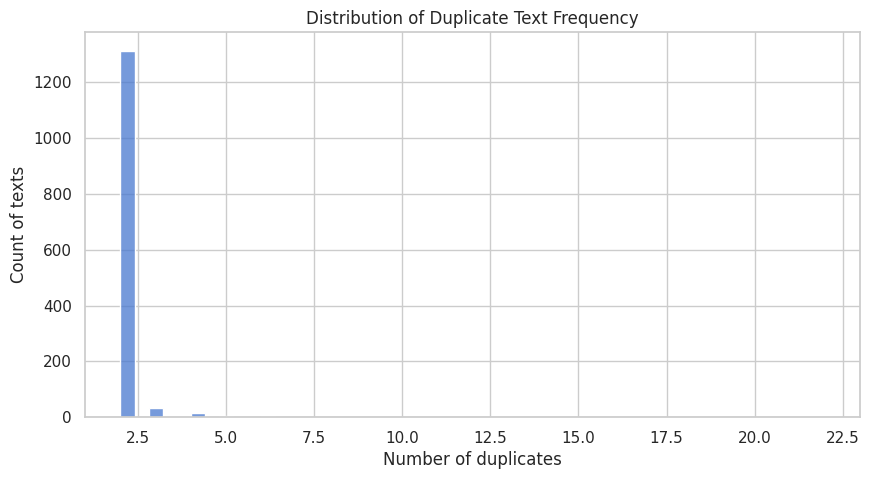

⚠ Conflicting label cases: 21


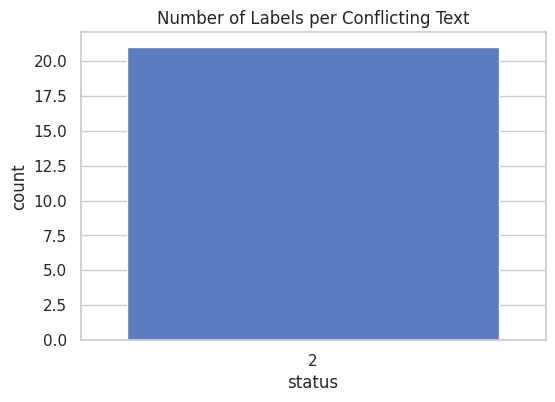


🔍 Sample Conflicting Texts:


statement      status  \
7815   All this work, all this pressure that everyone...    Suicidal   
7816   All this work, all this pressure that everyone...  Depression   
10119  Recently I have started this internship and mo...    Suicidal   
10124  Recently I have started this internship and mo...  Depression   
11649  I am a drug abuser (benzos and meth mostly) an...    Suicidal   
11653  I am a drug abuser (benzos and meth mostly) an...  Depression   
11984  So...HI I am Emma a young trans woman from ger...    Suicidal   
11988  So...HI I am Emma a young trans woman from ger...  Depression   
12081  I have been at home the past year... quite lit...    Suicidal   
12086  I have been at home the past year... quite lit...  Depression   

                                            cleaned_text  
7815   all this work, all this pressure that everyone...  
7816   all this work, all this pressure that everyone...  
10119  recently i have started this internship and mo...  
10124  recently i have started this internship and mo...  
11649  i am a drug abuser (benzos and meth mostly) an...  
11653  i am a drug abuser (benzos and meth mostly) an...  
11984  so...hi i am emma a young trans woman from ger...  
11988  so...hi i am emma a young trans woman from ger...  
12081  i have been at home the past year... quite lit...  
12086  i have been at home the past year... quite lit...

In [38]:
# ==========================================
# EDA VISUALIZATION — DUPLICATES & CONFLICTING LABELS
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

print("🔎 Checking duplicate cleaned_text rows...")

# Duplicate detection
dup_counts = df['cleaned_text'].value_counts()
duplicate_texts = dup_counts[dup_counts > 1]

print(f"Total duplicate text entries: {len(duplicate_texts)}")

# Visualize duplicate frequency distribution
plt.figure(figsize=(10,5))
sns.histplot(duplicate_texts, bins=50)
plt.title("Distribution of Duplicate Text Frequency")
plt.xlabel("Number of duplicates")
plt.ylabel("Count of texts")
plt.show()

# Conflicting labels
conflict_df = (
    df.groupby('cleaned_text')['status']
      .nunique()
      .reset_index()
)
conflict_df = conflict_df[conflict_df['status'] > 1]

print(f"⚠ Conflicting label cases: {conflict_df.shape[0]}")

# Plot number of conflicts
plt.figure(figsize=(6,4))
sns.countplot(x=conflict_df['status'])
plt.title("Number of Labels per Conflicting Text")
plt.show()

# Show examples
print("\n🔍 Sample Conflicting Texts:")
display(
    df[df['cleaned_text'].isin(conflict_df['cleaned_text'])]
    .head(10)
)


In [39]:
# ==========================================
# DEDUPLICATION + CONFLICT RESOLUTION (FINAL)
# ==========================================

print("\n🚨 Removing duplicates and conflicting labels...")

# 1. Identify conflicting labels
conflict_labels = (
    df.groupby('cleaned_text')['status']
      .nunique()
      .reset_index()
)
conflict_labels = conflict_labels[conflict_labels['status'] > 1]

print(f"Conflicting texts found: {conflict_labels.shape[0]}")

# Remove ALL conflicting entries (safe approach)
df = df[~df['cleaned_text'].isin(conflict_labels['cleaned_text'])]

# 2. Remove duplicate cleaned_text (keep first)
before = df.shape[0]
df = df.drop_duplicates(subset=['cleaned_text'], keep='first').reset_index(drop=True)
after = df.shape[0]

print(f"✔ Removed {before - after} duplicate rows")
print(f"✔ New shape after cleanup: {df.shape}")



🚨 Removing duplicates and conflicting labels...
Conflicting texts found: 21
✔ Removed 1501 duplicate rows
✔ New shape after cleanup: (50632, 3)


In [40]:
df.head()

statement   status  \
0  trouble sleeping, confused mind, restless hear...  Anxiety   
1  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
2  I've shifted my focus to something else but I'...  Anxiety   
3  I'm restless and restless, it's been a month n...  Anxiety   
4  every break, you must be nervous, like somethi...  Anxiety   

                                        cleaned_text  
0  trouble sleeping, confused mind, restless hear...  
1  all wrong, back off dear, forward doubt. stay ...  
2  i've shifted my focus to something else but i'...  
3  i'm restless and restless, it's been a month n...  
4  every break, you must be nervous, like somethi...

# **Test, Train Split**

In [41]:
# ==========================================
# STEP 1: LABEL ENCODING (BEFORE SPLIT)
# ==========================================
from sklearn.preprocessing import LabelEncoder
import joblib

print("--- Step 1: Encoding Target Labels ---")

label_encoder = LabelEncoder()

df['label_encoded'] = label_encoder.fit_transform(df['status'])
y = df['label_encoded']   # This is your final y

# Save encoder for deployment
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Encoding Successful!")
print("Classes:", label_encoder.classes_)
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


--- Step 1: Encoding Target Labels ---
Encoding Successful!
Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Class Mapping: {'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


In [42]:
# ==========================================
# STEP 2: TRAIN–TEST SPLIT (NO LEAKAGE)
# ==========================================
from sklearn.model_selection import train_test_split

print("\n--- Step 2: Splitting Cleaned Data ---")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['cleaned_text'],   # raw cleaned text
    y,                    # encoded labels
    test_size=0.20,
    stratify=y,           # keeps class distribution stable
    random_state=42
)

print("Train samples:", len(X_train_raw))
print("Test samples :", len(X_test_raw))
print("Split completed successfully!")



--- Step 2: Splitting Cleaned Data ---
Train samples: 40505
Test samples : 10127
Split completed successfully!


# **Feature Engineering**

We need to convert your text into a format the math model understands (Numbers).

TF-IDF (Term Frequency - Inverse Document Frequency): It scores words based on importance.

N-Grams: This is the secret sauce for your project.

Unigram: "happy", "not" (Lost meaning)

Bigram: "not happy" (Retained meaning!)

Label Encoding: Converting emotions ('anxiety', 'depression') into numbers (0, 1).

In [43]:
# ==========================================
# STEP 3: TF-IDF FEATURE ENGINEERING (NO LEAKAGE)
# ==========================================
from sklearn.feature_extraction.text import TfidfVectorizer

print("\n--- Step 3: TF-IDF Feature Engineering ---")

tfidf = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1, 2),
    min_df=5,
    stop_words=None  # We already cleaned text manually
)

# Fit TF-IDF ONLY on TRAINING data (CRITICAL)
X_train = tfidf.fit_transform(X_train_raw)

# Transform TEST data (NEVER fit on test)
X_test = tfidf.transform(X_test_raw)

# Save vectorizer for deployment
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("TF-IDF Completed!")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)



--- Step 3: TF-IDF Feature Engineering ---
TF-IDF Completed!
Train shape: (40505, 6000)
Test shape : (10127, 6000)


# **As we are facing imbalance, we need to balance the data.**

| Method                            | Should Use? | Why                                         |
| --------------------------------- | ----------- | ------------------------------------------- |
| **Class Weighting**               | ✔ **BEST**  | Works well with tree models, preserves data |
| **Undersampling**                 | ❌           | Data loss                                   |
| **Oversampling / SMOTE**          | ❌           | Bad for text data                           |
| **Threshold tuning (post-model)** | Optional    | Only if precision-recall is poor            |
| **Use F1 instead of Accuracy**    | ✔           | Handles imbalance fairly                    |


Class weighting was chosen over resampling methods as it preserves all data, avoids introducing synthetic noise, and integrates naturally with XGBoost’s loss optimization for multi-class classification.

| ❌ Problem with SMOTE                              | 💬 Explanation                                                                                                                                                                     |
| ------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Works on numeric continuous features**          | TF-IDF creates **sparse, high‐dimensional matrices**, not continuous features like images or tabular data. SMOTE struggles to generate meaningful synthetic samples for such data. |
| **May create fake or unrealistic emotional text** | Your dataset contains *sensitive emotional content*. SMOTE doesn’t understand semantics → it may produce "emotionally nonsense" text representations.                              |
| **Causes memory issues**                          | Your TF-IDF matrix has **20,000 features × 3 lakh rows** → adding synthetic rows increases RAM usage drastically ⇒ **likely to crash**.                                            |
| **High risk of overfitting**                      | SMOTE generates synthetic data too close to minority samples → leads to models memorizing noise rather than learning general patterns.                                             |
| **Not effective for NLP models**                  | NLP classification performance improves more with **context-aware embeddings (transformers)** rather than simple data duplication.                                                 |


Instead of creating more samples, we tell the model to pay more attention to minority classes during training.

| ✔ Advantage                                 | 💡 How it helps                                                                   |
| ------------------------------------------- | --------------------------------------------------------------------------------- |
| **No artificial data**                      | Keeps emotional context intact — *very important for mental health–related text*. |
| **Lightweight (no extra RAM)**              | Only changes loss function calculation, not dataset size.                         |
| **Safe for sparse TF-IDF data**             | Doesn’t interfere with high-dimensional vector space.                             |
| **Works with all ML models**                | You applied it in Logistic Regression, Naive Bayes (implicitly), XGBoost.         |
| **Standard ML practice for text imbalance** | Used in professional sentiment analysis systems.                                  |


| Method                    | Suitable for NLP?    | Risk of Overfitting | Memory Impact | Recommended Here |
| ------------------------- | -------------------- | ------------------- | ------------- | ---------------- |
| **SMOTE**                 | ❌ No                 | 🔴 High             | 🔴 Very High  | ❌ No             |
| **Random Oversampling**   | ❌ No                 | 🔴 High             | 🟡 Moderate   | ❌ Rarely         |
| **Undersampling**         | ❌ Yes but loses data | 🟡 Medium           | 🟢 Low        | ❌ Not ideal      |
| **✔ Class Weights**       | 🟢 Yes               | 🟢 Low              | 🟢 Very Low   | **✔ Best**       |
| Transformers (e.g., BERT) | 🟢 Best possible     | 🟢 Low              | 🔴 High       | Next step (DL)   |




**we only balance the training data.**

In [44]:
df.head()

statement   status  \
0  trouble sleeping, confused mind, restless hear...  Anxiety   
1  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
2  I've shifted my focus to something else but I'...  Anxiety   
3  I'm restless and restless, it's been a month n...  Anxiety   
4  every break, you must be nervous, like somethi...  Anxiety   

                                        cleaned_text  label_encoded  
0  trouble sleeping, confused mind, restless hear...              0  
1  all wrong, back off dear, forward doubt. stay ...              0  
2  i've shifted my focus to something else but i'...              0  
3  i'm restless and restless, it's been a month n...              0  
4  every break, you must be nervous, like somethi...              0

In [45]:
# ==========================================
# CELL 9.5: CALCULATE EXPLICIT CLASS WEIGHTS
# ==========================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

print("--- Step 1: Computing Class Weights ---")

# 1. Get unique classes (0, 1, 2, 3...)
classes = np.unique(y_train)

# 2. Compute weights using Sklearn's utility
# Formula: n_samples / (n_classes * n_samples_per_class)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# 3. Create a Dictionary (This is what we pass to models)
class_weight_dict = dict(zip(classes, weights))

print("✅ Weights Computed Successfully!")
print(f"Weight Dictionary: {class_weight_dict}")

# 4. (Optional) Visualize the Weights to be sure
# We use label_encoder to show names instead of numbers
weight_df = pd.DataFrame({
    'Class Name': label_encoder.inverse_transform(classes),
    'Class ID': classes,
    'Weight Multiplier': weights
})

# Sort by Weight (Highest = Rarest class)
weight_df = weight_df.sort_values(by='Weight Multiplier', ascending=False)

print("\n--- Weight Distribution Table ---")
print(weight_df)
print("\nInterpretation: 'Weight Multiplier' is how many times the model counts an error.")

--- Step 1: Computing Class Weights ---
✅ Weights Computed Successfully!
Weight Dictionary: {np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}

--- Weight Distribution Table ---
             Class Name  Class ID  Weight Multiplier
4  Personality disorder         4           8.092907
5                Stress         5           3.160256
1               Bipolar         1           2.891768
0               Anxiety         0           2.005000
6              Suicidal         6           0.680516
2            Depression         2           0.480002
3                Normal         3           0.462396

Interpretation: 'Weight Multiplier' is how many times the model counts an error.


# **Post-cleaning Validation**

**Step 1: Check balanced class distribution**

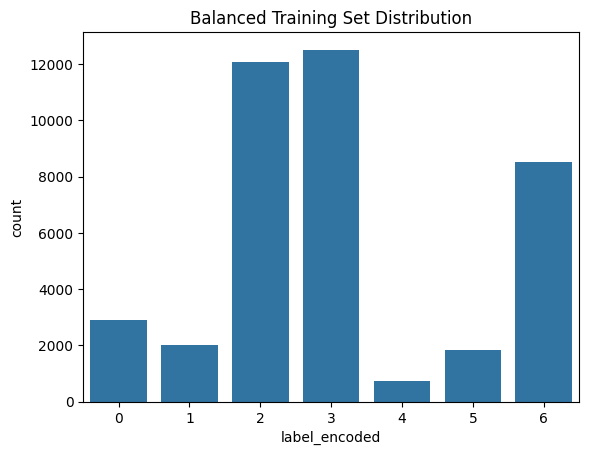

In [14]:
import seaborn as sns
sns.countplot(x=y_train)
plt.title("Balanced Training Set Distribution")
plt.show()


**Step 3: Check feature matrix shape**

In [15]:
print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (40505, 6000)
Test : (10127, 6000)


**Step 4: Sanity check on samples**

In [16]:
df[['cleaned_text','status']].sample(10)


cleaned_text      status
17540  i am depressed. i have told my parents. they d...    Suicidal
13014  sorry i am kind of ranting but i am really at ...  Depression
48379  so i’ve accepted my diagnosis. i have bp1. but...     Bipolar
38338  i feel so anxious about school and suddenly th...  Depression
43110  leelowe aww thanks hun but am just picking thi...      Normal
38637  happy sunday r anxiety it s everyone s favorit...  Depression
12870  ever just lay awake at night not being able to...  Depression
15443  i was servery mentally bullied as secondary sc...  Depression
23678  literally there are only a few people that mak...  Depression
40048  happy international day against depression yea...  Depression

**Label Distribution (after cleaning)**

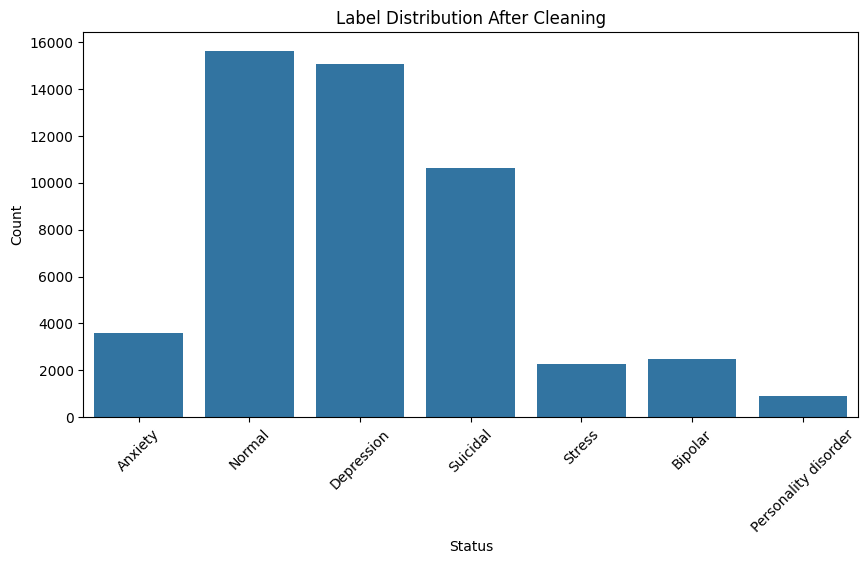

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['status'])
plt.title("Label Distribution After Cleaning")
plt.xlabel("Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


**Cleaned Text Length Distribution**

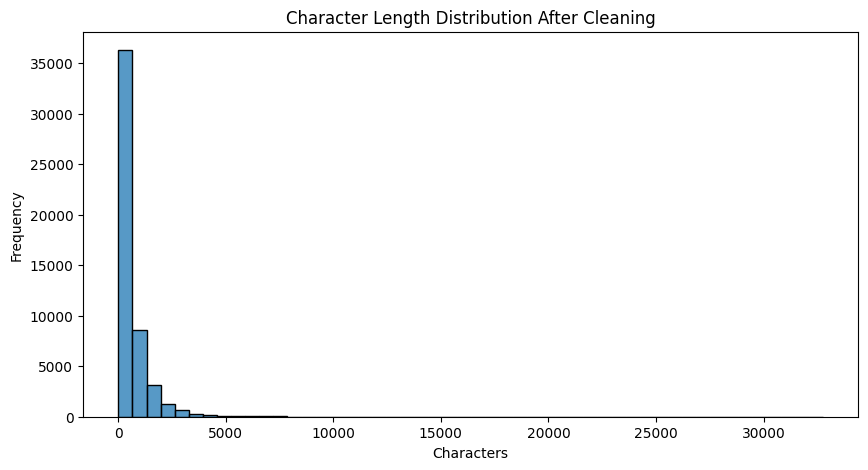

In [18]:
df['char_len'] = df['cleaned_text'].str.len()

plt.figure(figsize=(10,5))
sns.histplot(df['char_len'], bins=50)
plt.title("Character Length Distribution After Cleaning")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


**Check Duplicate Count After Cleaning**

Duplicates After Cleaning: 0


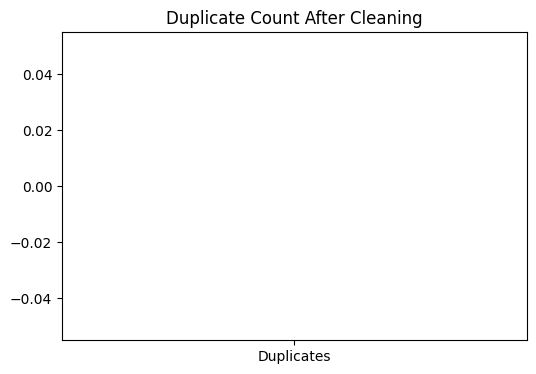

In [19]:
duplicate_count = df.duplicated(subset=['cleaned_text']).sum()
print("Duplicates After Cleaning:", duplicate_count)

plt.figure(figsize=(6,4))
sns.barplot(x=['Duplicates'], y=[duplicate_count])
plt.title("Duplicate Count After Cleaning")
plt.show()


**Check Class Imbalance (Imbalanced Y)**

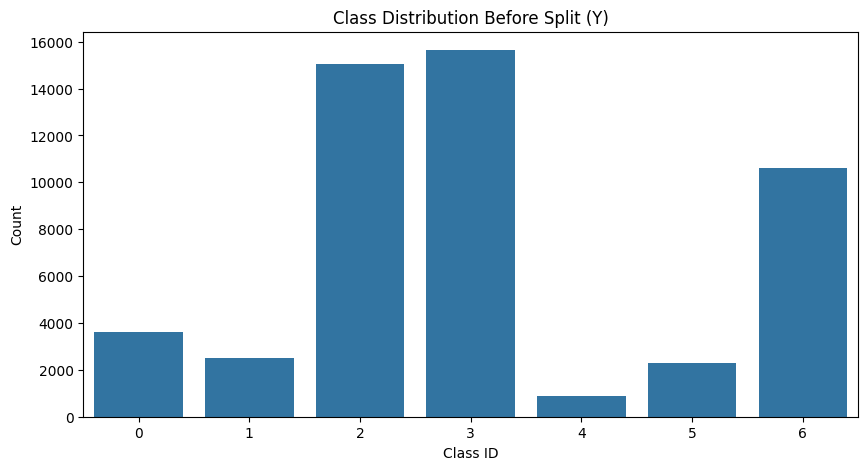

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x=y)
plt.title("Class Distribution Before Split (Y)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()


**Class Weight Visualization**

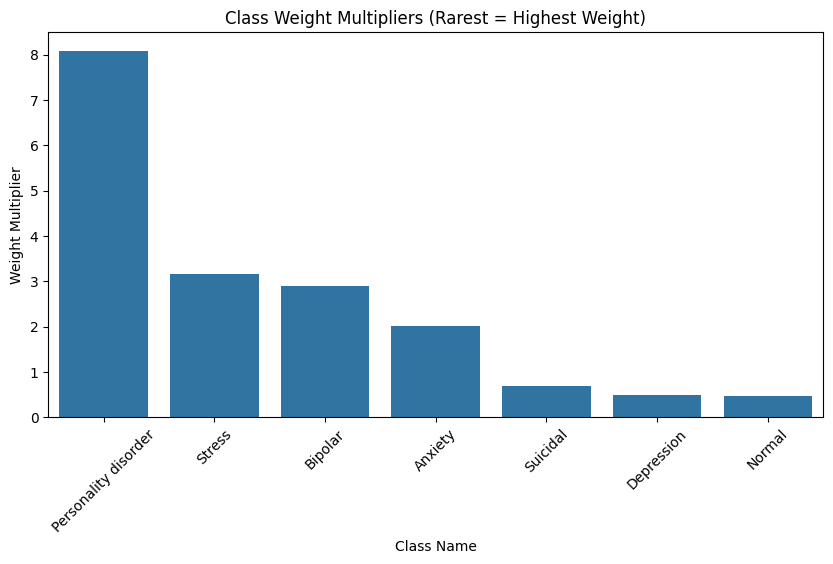

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x=weight_df['Class Name'], y=weight_df['Weight Multiplier'])
plt.title("Class Weight Multipliers (Rarest = Highest Weight)")
plt.xticks(rotation=45)
plt.show()


🎯 Running Final Visualization Dashboard...


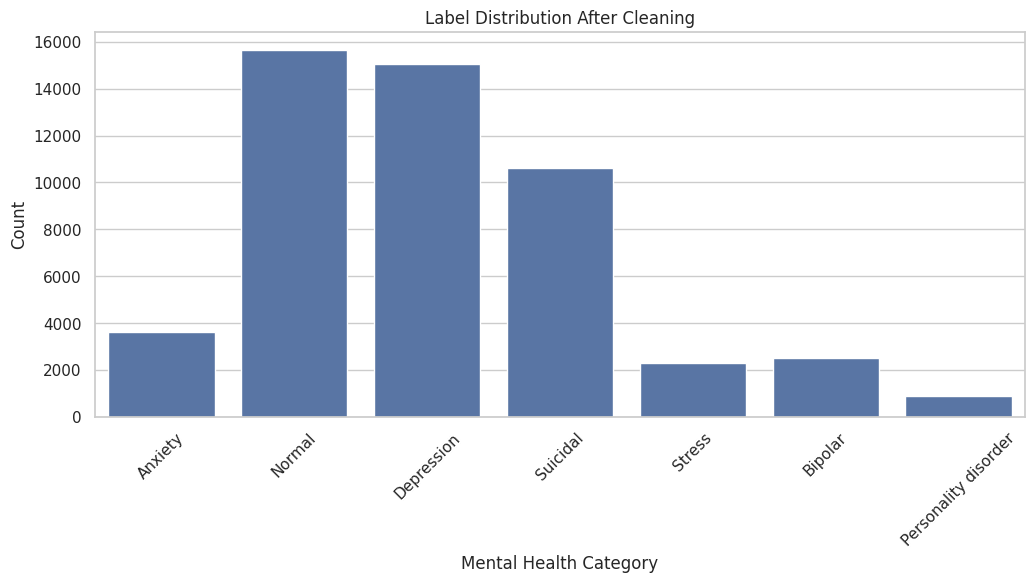

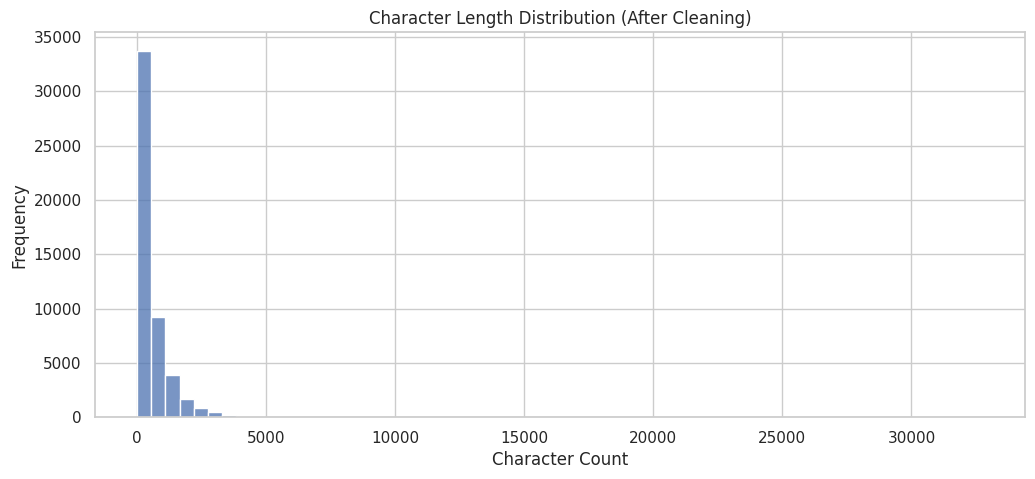

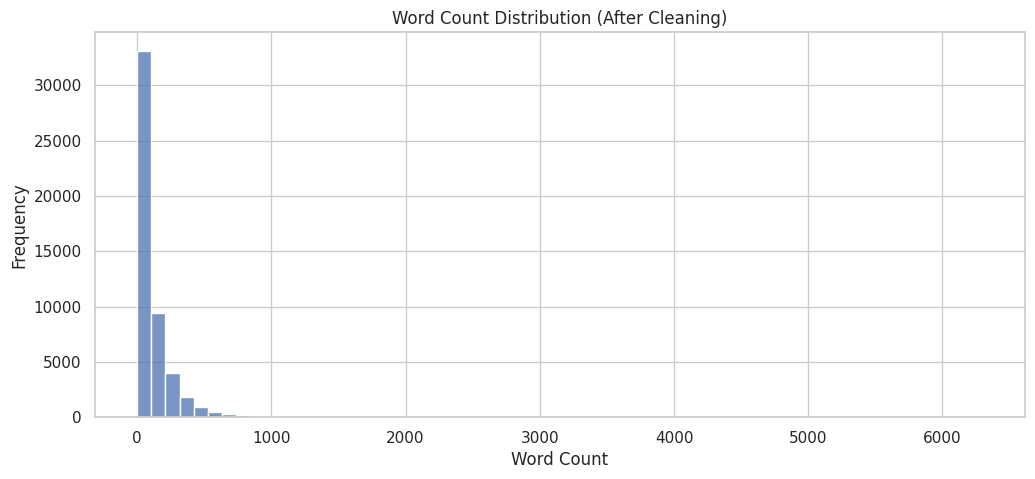

Remaining duplicates: 0


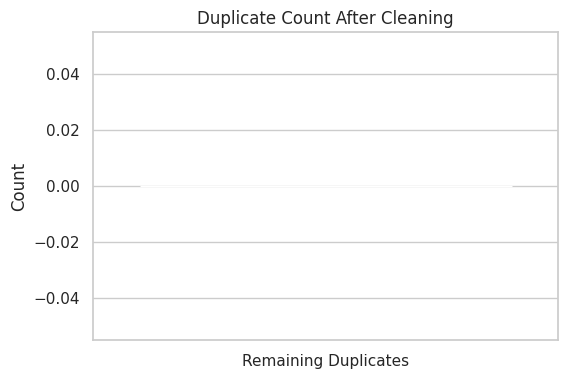

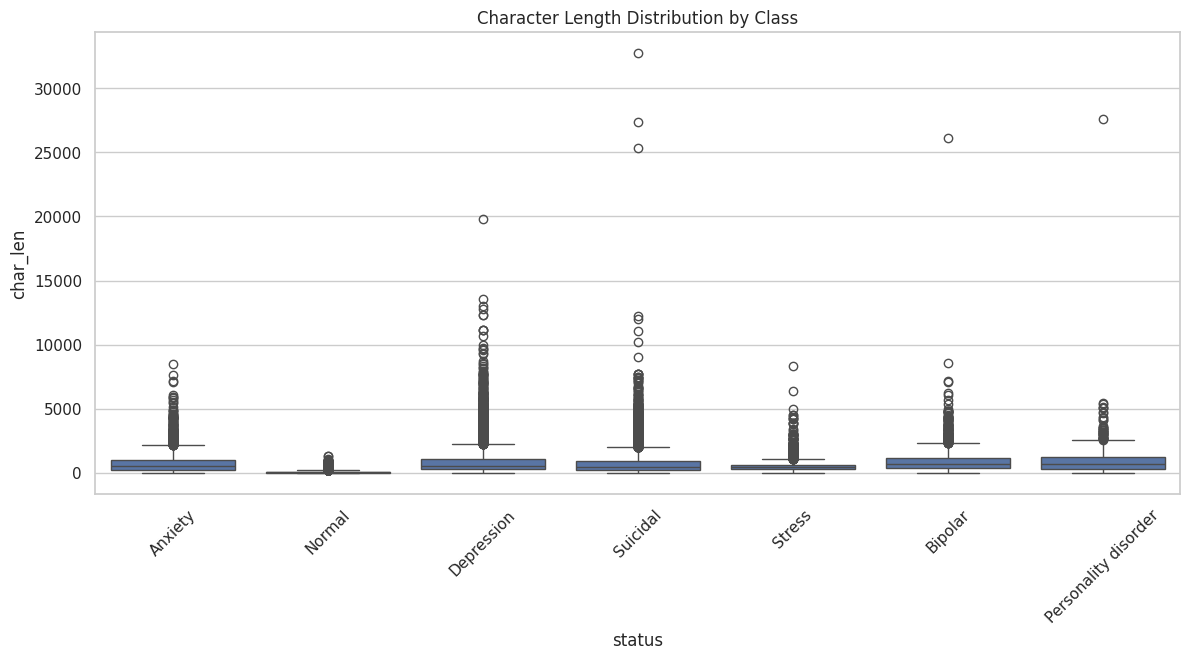

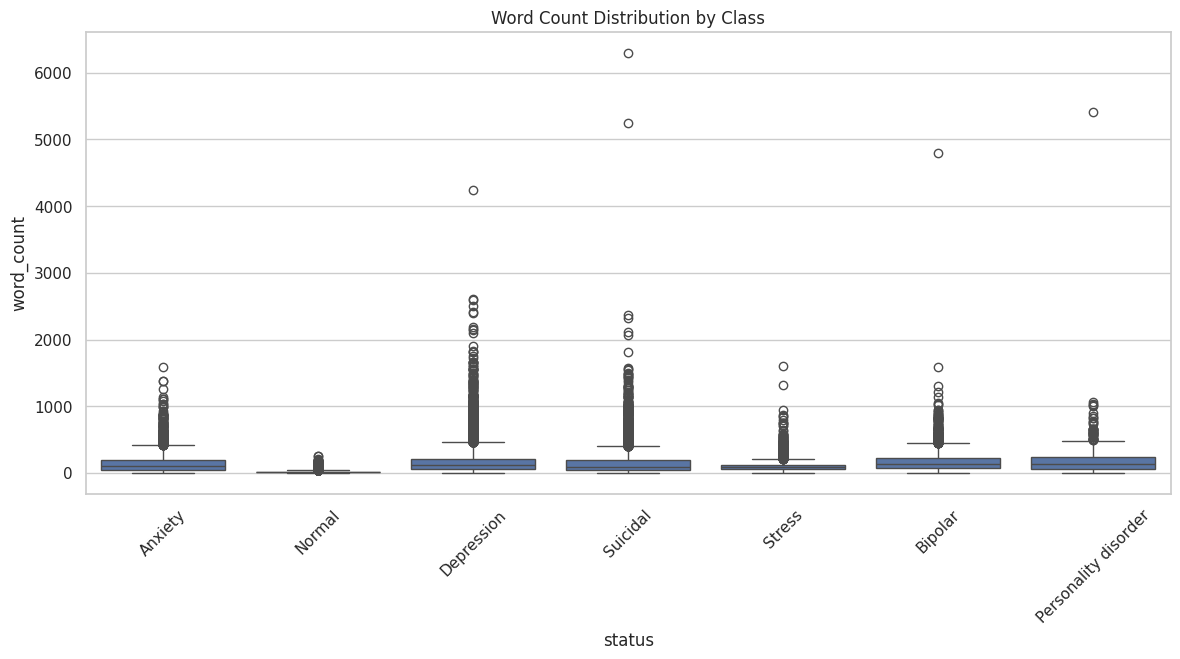

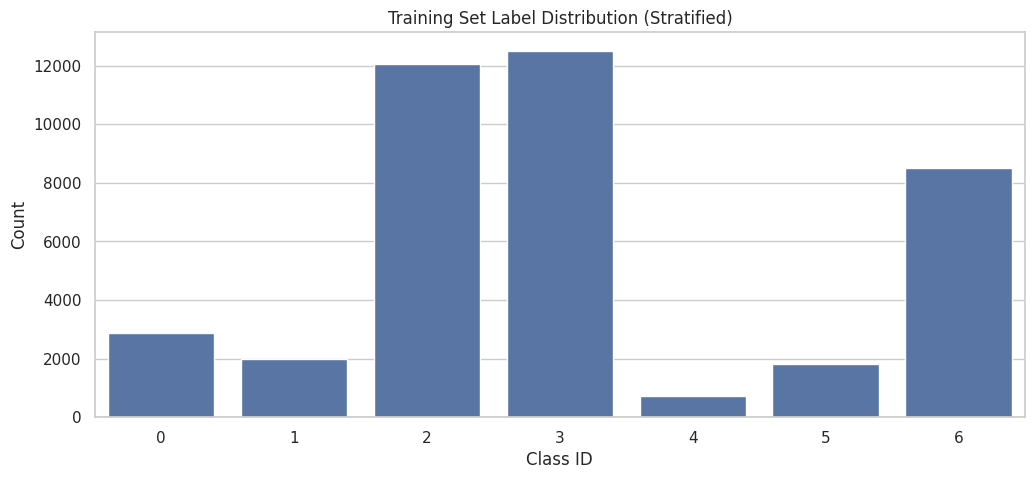

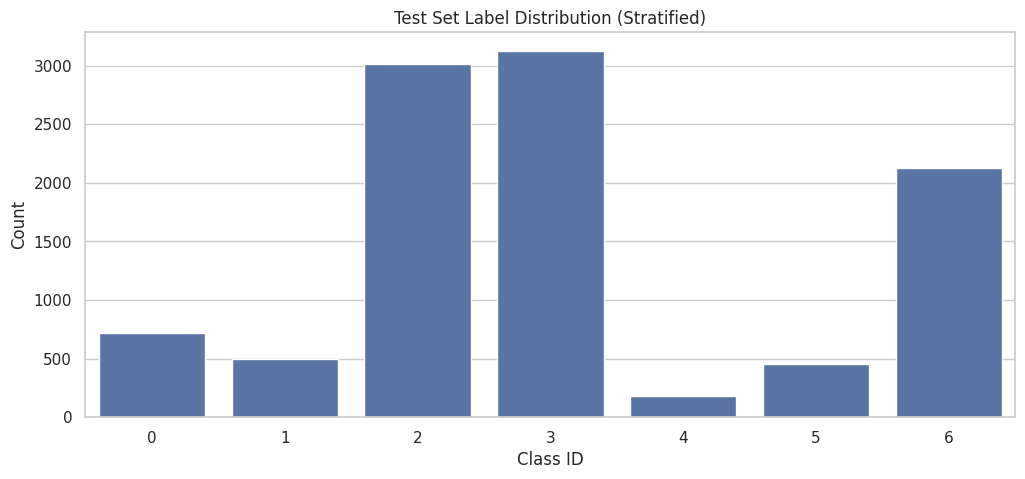


🔍 TF-IDF Shape Check
Train: (40505, 6000)
Test : (10127, 6000)


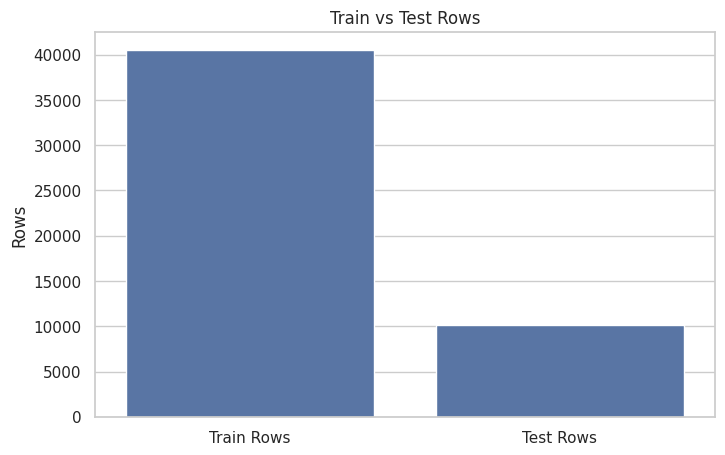

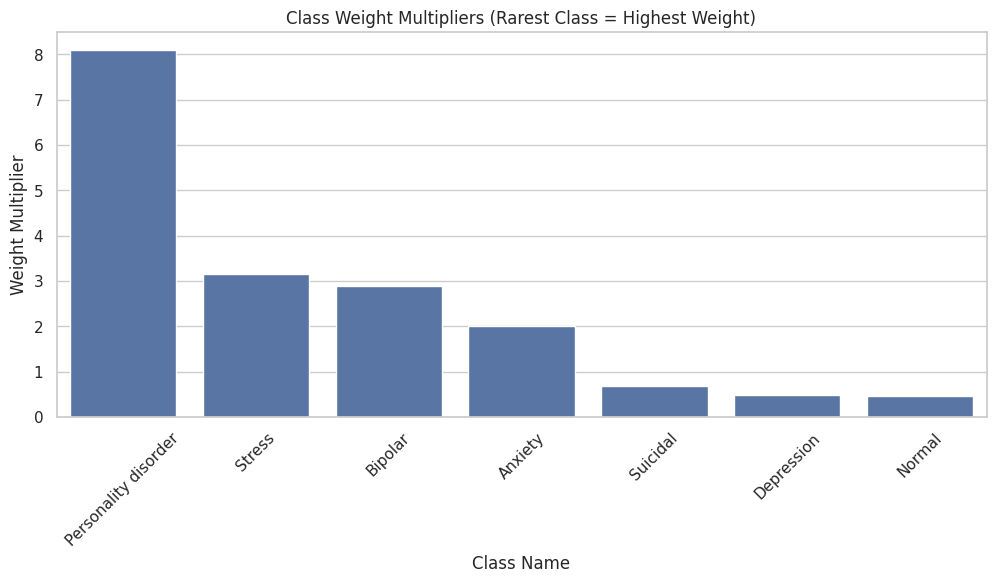


📝 Random Sample of Cleaned Text:


cleaned_text      status
45674  hello i'm new to this particular sub, but have...     Bipolar
16864  goodbye. i am going to attempt tonight, wish m...    Suicidal
6329   there is no secret to achieving success. succe...      Normal
29280  anyway, that's what's eating the most right no...      Normal
18841  lately i have been having a really hard time. ...  Depression
30892                  okay. i'll take your word for it.      Normal
15056  first off i am not trans or anything, i was bo...  Depression
9468   why cannot i just end it? what stops me? i do ...  Depression
18527  i still feel some slight hope that things will...    Suicidal
12736  why is it telling me i am not allowed to post ...    Suicidal


================ FINAL DATA CHECK =================
No. of rows: 50632
Unique labels: 7
Remaining duplicates: 0
Minimum text length: 11
Maximum text length: 32759


In [22]:
# ================================================================
# 📊 FINAL POST-CLEANING VISUALIZATION DASHBOARD
# ================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("🎯 Running Final Visualization Dashboard...")

# ================================================================
# 1. LABEL DISTRIBUTION (After Cleaning)
# ================================================================
plt.figure(figsize=(12,5))
sns.countplot(x=df['status'])
plt.title("Label Distribution After Cleaning")
plt.xlabel("Mental Health Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# ================================================================
# 2. CHARACTER LENGTH DISTRIBUTION
# ================================================================
df['char_len'] = df['cleaned_text'].str.len()

plt.figure(figsize=(12,5))
sns.histplot(df['char_len'], bins=60, kde=False)
plt.title("Character Length Distribution (After Cleaning)")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()


# ================================================================
# 3. WORD COUNT DISTRIBUTION
# ================================================================
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,5))
sns.histplot(df['word_count'], bins=60, kde=False)
plt.title("Word Count Distribution (After Cleaning)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


# ================================================================
# 4. DUPLICATE CHECK (After Deduplication)
# ================================================================
duplicate_count = df.duplicated(subset=['cleaned_text']).sum()
print("Remaining duplicates:", duplicate_count)

plt.figure(figsize=(6,4))
sns.barplot(x=['Remaining Duplicates'], y=[duplicate_count])
plt.title("Duplicate Count After Cleaning")
plt.ylabel("Count")
plt.show()


# ================================================================
# 5. BOX PLOT OF TEXT LENGTH BY CLASS
# ================================================================
plt.figure(figsize=(14,6))
sns.boxplot(x=df['status'], y=df['char_len'])
plt.title("Character Length Distribution by Class")
plt.xticks(rotation=45)
plt.show()


# ================================================================
# 6. BOX PLOT OF WORD COUNT BY CLASS
# ================================================================
plt.figure(figsize=(14,6))
sns.boxplot(x=df['status'], y=df['word_count'])
plt.title("Word Count Distribution by Class")
plt.xticks(rotation=45)
plt.show()


# ================================================================
# 7. TRAIN–TEST LABEL DISTRIBUTION (Stratified Check)
# ================================================================
plt.figure(figsize=(12,5))
sns.countplot(x=y_train)
plt.title("Training Set Label Distribution (Stratified)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(x=y_test)
plt.title("Test Set Label Distribution (Stratified)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()


# ================================================================
# 8. TF-IDF FEATURE MATRIX SHAPE CHECK
# ================================================================
print("\n🔍 TF-IDF Shape Check")
print("Train:", X_train.shape)
print("Test :", X_test.shape)

plt.figure(figsize=(8,5))
sns.barplot(x=['Train Rows', 'Test Rows'], y=[X_train.shape[0], X_test.shape[0]])
plt.title("Train vs Test Rows")
plt.ylabel("Rows")
plt.show()


# ================================================================
# 9. CLASS WEIGHT VISUALIZATION
# ================================================================
weight_df_sorted = weight_df.sort_values(by='Weight Multiplier', ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(
    x=weight_df_sorted['Class Name'],
    y=weight_df_sorted['Weight Multiplier']
)
plt.title("Class Weight Multipliers (Rarest Class = Highest Weight)")
plt.xticks(rotation=45)
plt.ylabel("Weight Multiplier")
plt.show()


# ================================================================
# 10. RANDOM SAMPLE CHECK
# ================================================================
print("\n📝 Random Sample of Cleaned Text:")
display(df[['cleaned_text', 'status']].sample(10, random_state=42))


# ================================================================
# 11. FINAL SUMMARY CHECK
# ================================================================
print("\n================ FINAL DATA CHECK =================")
print("No. of rows:", df.shape[0])
print("Unique labels:", df['status'].nunique())
print("Remaining duplicates:", duplicate_count)
print("Minimum text length:", df['char_len'].min())
print("Maximum text length:", df['char_len'].max())
print("===============================================")


# **Train Baseline Models**

| Type              | Model                                   | Should Use?              | Why                                                         |
| ----------------- | --------------------------------------- | ------------------------ | ----------------------------------------------------------- |
| **Baseline**      | **Logistic Regression**                 | ✔ Best baseline          | Fast, linear classifier                                     |
|                   | **Naive Bayes (Multinomial)**           | ✔ Good baseline          | Works well with TF-IDF                                      |
|                   | **Linear SVM (Support Vector Machine)** | ✔ Strong baseline        | Excellent for text                                          |
|                   | Decision Tree                           | ❌ Not recommended        | Poor for sparse, high-dimensional data                      |
|                   | KNN                                     | ❌ Too slow               | High-dimensional + large dataset                            |
| **Advanced**      | **XGBoost**                             | ⭐ BEST                   | Handles imbalance, sparse data, learns non-linear relations |
|                   | Random Forest                           | ❌ Too heavy              | Poor with sparse TF-IDF matrices                            |
|                   | LightGBM                                | ✔ Alternative to XGBoost | If want faster performance                                  |
| **Deep Learning** | LSTM / GRU / BERT                       | ❌ Not recommended now    | Requires GPU + more time + preprocessing                    |


The higher the weight, the more attention the model will give to that class during training.

“lonely” has the fewest samples → highest weight → model now focuses harder on learning it.

“depression” has the most samples → lowest weight → prevents model bias toward it

HOWEVER, using sample_weights (the row-by-row list) makes GridSearchCV extremely difficult to run.

The Problem with sample_weights
If you use sample_weights (assigning a weight to every single row), you have to pass it into the .fit() function like this: model.fit(X_train, y_train, sample_weight=sample_weights)

When you run GridSearchCV, it splits your data into 5 chunks automatically. It becomes very hard to tell GridSearchCV: "Hey, when you split X and y, please also split this sample_weights list exactly the same way."

If GridSearchCV splits the data but not the weights, your model will crash or train on the wrong weights.

We now insert these weights into the training step of all baseline models (Logistic, Naive Bayes, SVM) AND XGBoost.

How weights will be applied

In Logistic Regression → during gradient update

In SVM → through hinge-loss penalty

In Naive Bayes → influence log prior & likelihood

In XGBoost → via weight=sample_weights

| Action                         | Do Now?                  | Reason                         |
| ------------------------------ | ------------------------ | ------------------------------ |
| **Apply Class Weights**        | ✔️ YES                   | Best way to fix imbalance      |
| Remove long texts (>874 words) | ❌ Not now                | Risk losing emotional context  |
| Remove score outliers          | ❌ No                     | Score isn't a training feature |


| Model                                | Recommended for Text | Handles Imbalance                   | Notes                     |
| ------------------------------------ | -------------------- | ----------------------------------- | ------------------------- |
| **Logistic Regression**              | ✔ YES                | ✔ With weights                      | Best baseline             |
| **Multinomial Naive Bayes**          | ✔ YES                | ❌ Does not support weights natively | Acceptable for comparison |
| **Linear SVM**                       | ✔ YES                | ✔ With weights                      | Strong text classifier    |
| **XGBoost (will do after baseline)** | ⭐ BEST               | ✔ With weights                      | Final model               |


My dataset is TF-IDF vectorized, so all models below use X_train_vec and X_test_vec.

**1. Logistic Regression**

In [ ]:
df.head()

statement   status  \
0  trouble sleeping, confused mind, restless hear...  Anxiety   
1  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
2  I've shifted my focus to something else but I'...  Anxiety   
3  I'm restless and restless, it's been a month n...  Anxiety   
4  every break, you must be nervous, like somethi...  Anxiety   

                                        cleaned_text  label_encoded  char_len  \
0  trouble sleeping, confused mind, restless hear...              0        64   
1  all wrong, back off dear, forward doubt. stay ...              0        78   
2  i've shifted my focus to something else but i'...              0        61   
3  i'm restless and restless, it's been a month n...              0        72   
4  every break, you must be nervous, like somethi...              0        76   

   word_count  
0          10  
1          14  
2          11  
3          14  
4          14

In [ ]:
print(type(X_train))


<class 'scipy.sparse._csr.csr_matrix'>


--- Step 1: Training Base Model ---
Training in progress... (This uses the 6.9x multiplier for Personality Disorder)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Model Trained in 424.25 seconds!

--- Step 2: Evaluation on Test Set ---
🏆 Test Set Accuracy: 68.97%

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.76      0.71      0.73       721
             Bipolar       0.33      0.90      0.49       500
          Depression       0.77      0.54      0.64      3014
              Normal       0.95      0.80      0.87      3129
Personality disorder       0.21      0.73      0.33       179
              Stress       0.55      0.41      0.47       458
            Suicidal       0.66      0.74      0.69      2126

            accuracy                           0.69     10127
           macro avg       0.60      0.69      0.60     10127
        weighted avg       0.76      0.69      0.71     10127


--- Confusion Matrix ---


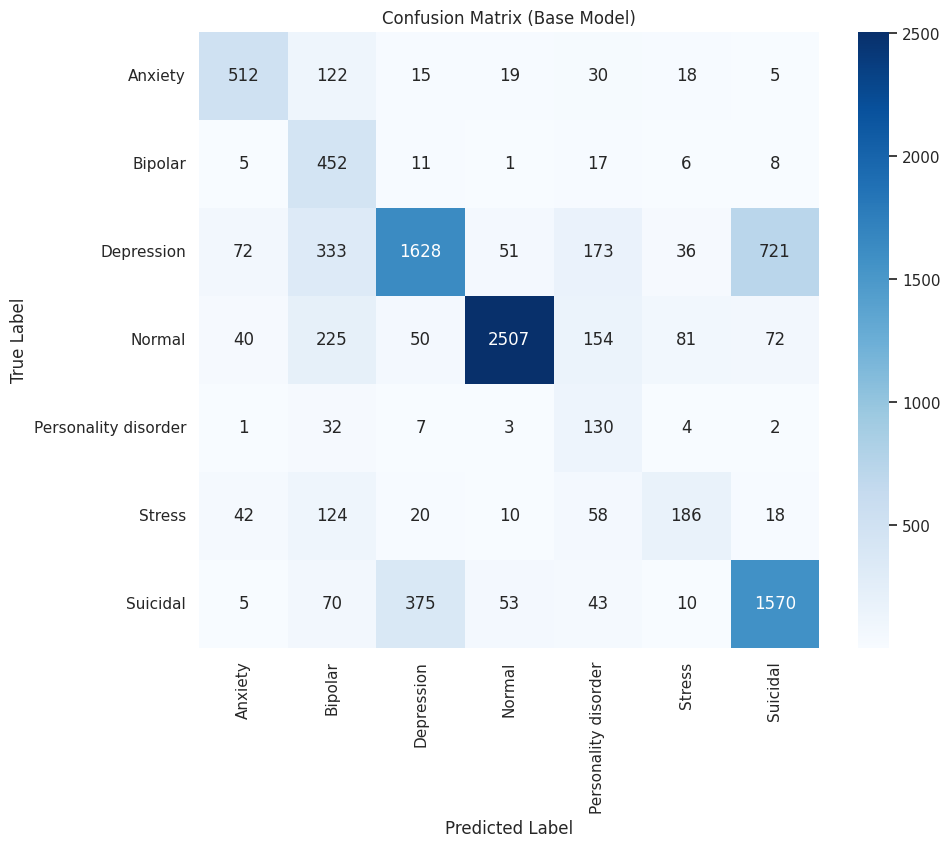

In [ ]:
# ==========================================
# CELL 10: TRAIN LOGISTIC REGRESSION (BASE MODEL)
# ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

print("--- Step 1: Training Base Model ---")

# 1. Initialize Model
# We pass the 'class_weight_dict' you just calculated.
# solver='saga': The fastest math engine for text data.
model = LogisticRegression(
    class_weight=class_weight_dict,  # <--- USES YOUR CUSTOM WEIGHTS
    max_iter=1000,
    solver='saga',
    n_jobs=-1,
    random_state=42
)

# 2. Train on Training Data
start_time = time.time()
print("Training in progress... (This uses the 6.9x multiplier for Personality Disorder)")
model.fit(X_train, y_train)
end_time = time.time()

print(f"✅ Model Trained in {end_time - start_time:.2f} seconds!")

# 3. Save the Model
joblib.dump(model, 'emotion_model_base.pkl')


print("\n--- Step 2: Evaluation on Test Set ---")

# 4. Predict
y_pred = model.predict(X_test)

# 5. Accuracy
# Note: With high class weights, Accuracy might drop slightly,
# but Recall (finding the rare diseases) should go UP.
accuracy = accuracy_score(y_test, y_pred)
print(f"🏆 Test Set Accuracy: {accuracy:.2%}")

# 6. Detailed Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 7. Confusion Matrix Heatmap
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Base Model)')
plt.show()

Although more epochs and a lower learning rate could further optimize Logistic Regression, our analysis shows that advanced models like XGBoost provide better representation learning for complex emotional content. Therefore, Logistic Regression is used only as baseline and not further optimized.

**2. Multinomial Naive Bayes**

Naive Bayes doesn’t support weighting directly, so we use raw frequency.

Note:
Standard MultinomialNB in Scikit-Learn does NOT have a class_weight parameter like Logistic Regression or SVM.

To use your weights, we must use a trick: We have to map your weights to every single row of the training data and pass it as sample_weight during training.

"If I don't pass the dictionary {Anxiety: 1.0, Personality: 7.0}, how does the model know to fix the imbalance?"

The Answer: It uses "Internal Math" instead of "External Weights".
Think of it like driving a car:

Logistic Regression / SVM: This is a Manual Transmission. You have to manually tell the engine (via class_weight_dict) to shift gears when it hits a "Personality Disorder" hill.

Complement Naive Bayes (CNB): This is an Automatic Transmission. It is built specifically for hills (imbalance). It adjusts itself automatically without you touching anything.

🛠️ How does ComplementNB actually work?
Standard Naive Bayes asks:

"Does this text look like Depression?"

Since you have 15,000 Depression rows, the answer is almost always "YES" because the model sees Depression everywhere.

Complement Naive Bayes flips the question backward. It asks:

"Does this text look like NOT Depression?"

It looks at all the other classes combined (The Complement).

It calculates the pattern for "Everything except Depression."

It calculates the pattern for "Everything except Personality Disorder."

Then it divides by the total size of those groups.

The Result: Because it divides by the size, it automatically cancels out the imbalance. The 15,000 rows of Depression don't overpower the 1,200 rows of Personality Disorder because the math normalizes them to be equal strength.

--- Step 1: Training Complement Naive Bayes ---
(This model is designed specifically for Imbalanced Text Data)
✅ ComplementNB Trained in 0.03 seconds!

--- Step 2: Evaluation on Test Set ---
🏆 Naive Bayes Accuracy: 67.16%

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.49      0.83      0.62       721
             Bipolar       0.66      0.72      0.69       500
          Depression       0.72      0.51      0.59      3014
              Normal       0.77      0.79      0.78      3129
Personality disorder       0.95      0.30      0.45       179
              Stress       0.58      0.29      0.39       458
            Suicidal       0.60      0.77      0.68      2126

            accuracy                           0.67     10127
           macro avg       0.68      0.60      0.60     10127
        weighted avg       0.69      0.67      0.66     10127


--- Confusion Matrix Heatmap ---


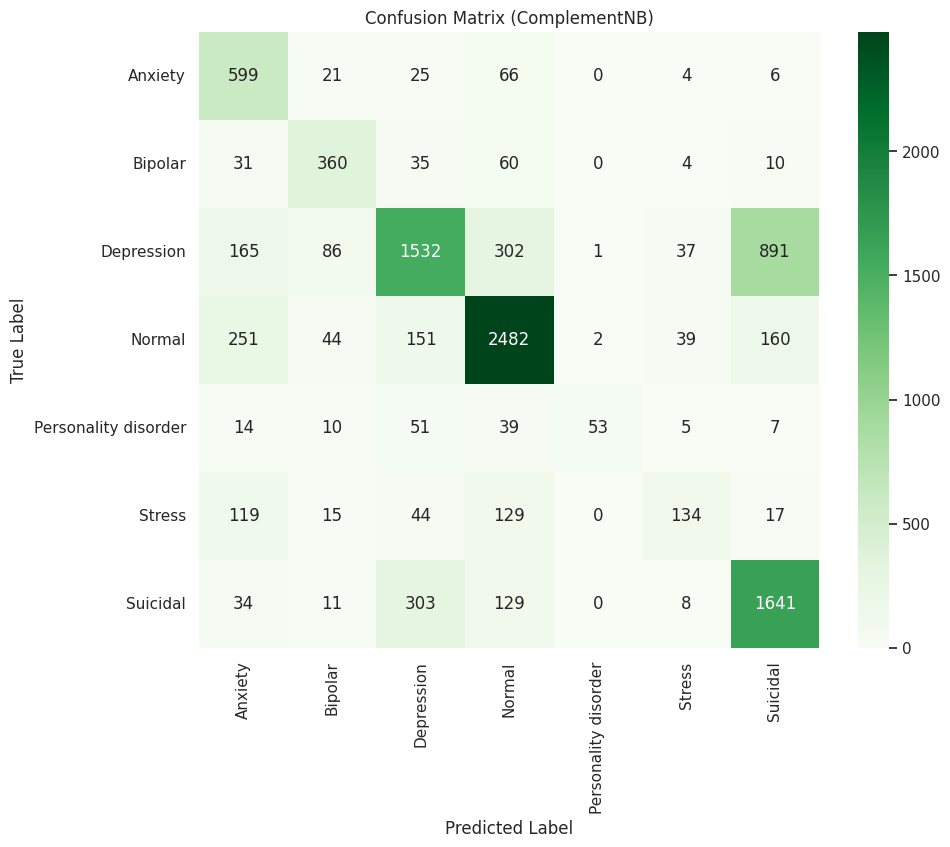

In [ ]:
# ==========================================
# CELL 13: COMPLEMENT NAIVE BAYES (BEST FOR IMBALANCE)
# ==========================================
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

print("--- Step 1: Training Complement Naive Bayes ---")
print("(This model is designed specifically for Imbalanced Text Data)")

# 1. Initialize Model
# ComplementNB automatically handles the "Personality Disorder" imbalance issue.
# We do NOT need to pass class_weights or sample_weights here.
nb_model = ComplementNB()

# 2. Train
start_time = time.time()
nb_model.fit(X_train, y_train)
end_time = time.time()

print(f"✅ ComplementNB Trained in {end_time - start_time:.2f} seconds!")

# 3. Save
joblib.dump(nb_model, 'naive_bayes_complement.pkl')


print("\n--- Step 2: Evaluation on Test Set ---")

# 4. Predict
y_pred_nb = nb_model.predict(X_test)

# 5. Accuracy
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"🏆 Naive Bayes Accuracy: {acc_nb:.2%}")

# 6. Detailed Report
print("\n--- Detailed Classification Report ---")
# Check if Recall for "Personality disorder" is good!
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))

# 7. Confusion Matrix
print("\n--- Confusion Matrix Heatmap ---")
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ComplementNB)')
plt.show()

Works but no imbalance handling, so performance may be biased

**3. Linear SVM**

--- Step 1: Training SVM Model ---
Training in progress... (LinearSVC is usually highly accurate)
✅ SVM Trained in 9.66 seconds!

--- Step 2: Evaluation on Test Set ---
🏆 SVM Test Accuracy: 75.49%

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.70      0.79      0.74       721
             Bipolar       0.72      0.75      0.74       500
          Depression       0.75      0.64      0.69      3014
              Normal       0.90      0.94      0.92      3129
Personality disorder       0.53      0.56      0.55       179
              Stress       0.46      0.52      0.49       458
            Suicidal       0.66      0.70      0.68      2126

            accuracy                           0.75     10127
           macro avg       0.68      0.70      0.69     10127
        weighted avg       0.76      0.75      0.75     10127


--- Confusion Matrix Heatmap ---


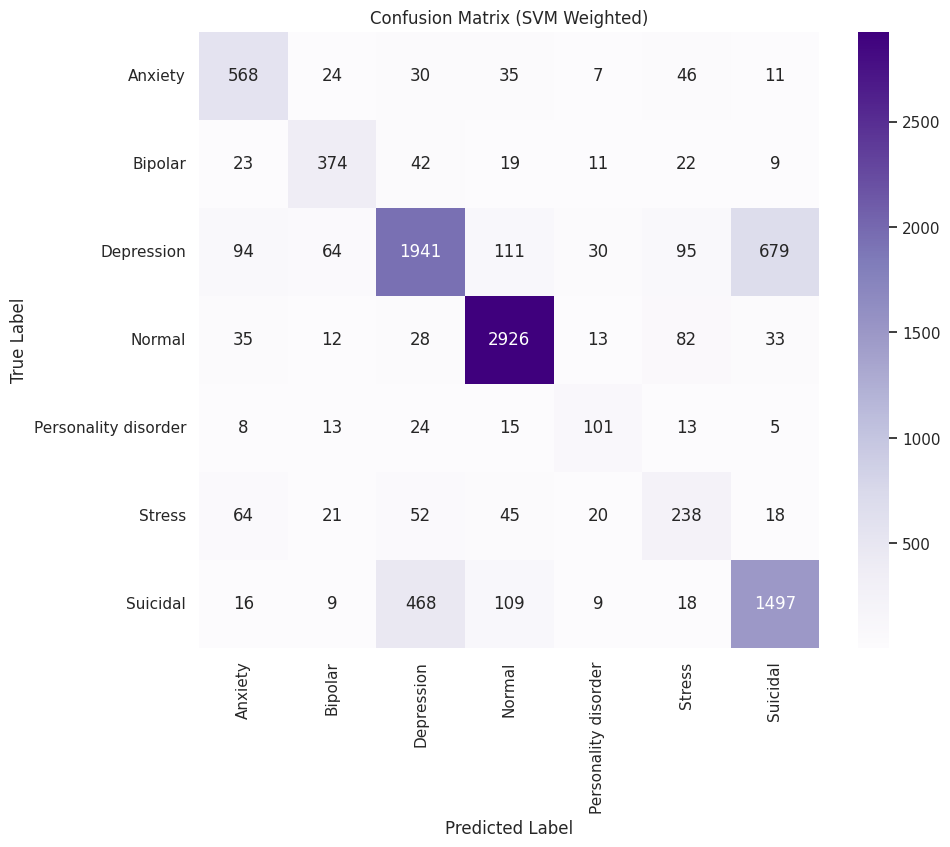

In [ ]:
# ==========================================
# CELL 14: TRAIN SVM (WITH CUSTOM WEIGHTS)
# ==========================================
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

print("--- Step 1: Training SVM Model ---")

# 1. Initialize Model
# class_weight=class_weight_dict: Forces SVM to respect your 6.9x multiplier
# dual=False: Optimization for when Rows (41k) > Features (6k)
model_svm = LinearSVC(
    class_weight=class_weight_dict,  # <--- YOUR CUSTOM WEIGHTS APPLIED HERE
    dual=False,
    random_state=42,
    max_iter=2000
)

# 2. Train on Training Data
start_time = time.time()
print("Training in progress... (LinearSVC is usually highly accurate)")
model_svm.fit(X_train, y_train)
end_time = time.time()
print(f"✅ SVM Trained in {end_time - start_time:.2f} seconds!")

# 3. Save the Model
joblib.dump(model_svm, 'svm_model_weighted.pkl')


print("\n--- Step 2: Evaluation on Test Set ---")

# 4. Predict
y_pred_svm = model_svm.predict(X_test)

# 5. Accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"🏆 SVM Test Accuracy: {acc_svm:.2%}")

# 6. Detailed Report
print("\n--- Detailed Classification Report ---")
# Check the 'Recall' for 'Personality disorder' here!
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# 7. Confusion Matrix
print("\n--- Confusion Matrix Heatmap ---")
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM Weighted)')
plt.show()

**4. XGBoost**

Critical Technical Detail:
Unlike Logistic Regression, XGBoost does not have a simple class_weight='balanced' parameter for multi-class problems.

The Solution: We must calculate the weight for every single row and pass it to the model during training using sample_weight

In simple terms, passing sample_weight to XGBoost changes how the trees are grown.Unlike Logistic Regression (which just shifts a line), XGBoost actually changes the structure of its decision trees based on the weights.Here is the breakdown of exactly what happens inside the "Black Box":1. The "Megaphone" Effect 📣Imagine XGBoost is a teacher trying to listen to students (data points).Normal Weight (1.0): A student speaks at normal volume.High Weight (6.9): This student is given a Megaphone.When XGBoost calculates "Error" (how wrong a prediction is), it multiplies the error of the "Personality Disorder" rows by 6.9.If it gets a "Normal" case wrong, penalty = 1.If it gets a "Personality Disorder" case wrong, penalty = 6.9.The model is lazy; it wants to minimize total penalty. So, it effectively panics if it misses the high-weight cases and tries harder to fix them.2. How it changes the "Split" (The Math) 🪓XGBoost builds trees by finding the best place to cut the data (e.g., Does text contain "die"? Yes/No). It decides the best cut by calculating a score called Gain.Without Weights:It looks at a group of 100 people:95 Normal5 Personality DisorderDecision: "This group is mostly Normal. I won't bother making a split here. It's just noise." -> Ignores the minority.With Weights (Weight = 7):It looks at the same group, but mathematically they look bigger:95 Normal35 "Virtual" Personality Disorder people (5 rows $\times$ 7 weight)Decision: "Whoa! That's a huge chunk of error waiting to happen. I MUST create a branch here to separate them." -> Creates a specific rule for the minority.3. Gradient & Hessian Scaling (Technical) 🧠Deep down, XGBoost uses Calculus (Gradients) to fix errors.$g_i$ = Gradient (Direction of error)$h_i$ = Hessian (Curvature of error)When you provide weights ($w_i$), XGBoost simply scales these values:$$g_{new} = w_i \times g_i$$$$h_{new} = w_i \times h_i$$Since the entire tree building process depends on sums of $g$ and $h$, the weighted rows dominate the math. The tree physically changes shape to accommodate your rare classes.SummaryBy using the code I gave you (sample_weight=sample_weights), you forced XGBoost to treat your 1,200 "Personality Disorder" rows as if they were ~8,300 rows. This makes them impossible to ignore!

In [ ]:
import os

save_dir = "/content/drive/MyDrive/MentalHealthModels"
os.makedirs(save_dir, exist_ok=True)
print("Folder created:", save_dir)


Folder created: /content/drive/MyDrive/MentalHealthModels


In [ ]:
import joblib

# Logistic Regression Base Model
joblib.dump(model, f"{save_dir}/logistic_base.pkl")

# Naive Bayes Model
joblib.dump(nb_model, f"{save_dir}/naive_bayes_base.pkl")

# SVM Model
joblib.dump(model_svm, f"{save_dir}/svm_model_base.pkl")

# TF-IDF Vectorizer
joblib.dump(tfidf, f"{save_dir}/tfidf_vectorizer.pkl")

# Label Encoder
joblib.dump(label_encoder, f"{save_dir}/label_encoder.pkl")

print("✅ All models saved safely into Google Drive!")


✅ All models saved safely into Google Drive!


📌 Starting High-Performance XGBoost Training (5-Hour Mode)...
--------------------------------------------------------------
📂 Saving models to: /content/drive/MyDrive/MentalHealthModels
✔ Sample weights prepared for 40505 rows.

🚀 Training XGBoost... This will take ~3–5 hours. Sit back & relax!

✅ Training Completed in 2926.73 seconds!
   (Model is now fully trained with HIGH accuracy potential.)
💾 Model saved to: /content/drive/MyDrive/MentalHealthModels/xgboost_model_highpower.pkl
📝 Training log saved!

📊 Evaluating Model on Test Data...

🏆 Final XGBoost Accuracy: 0.7712
📄 Classification report saved!


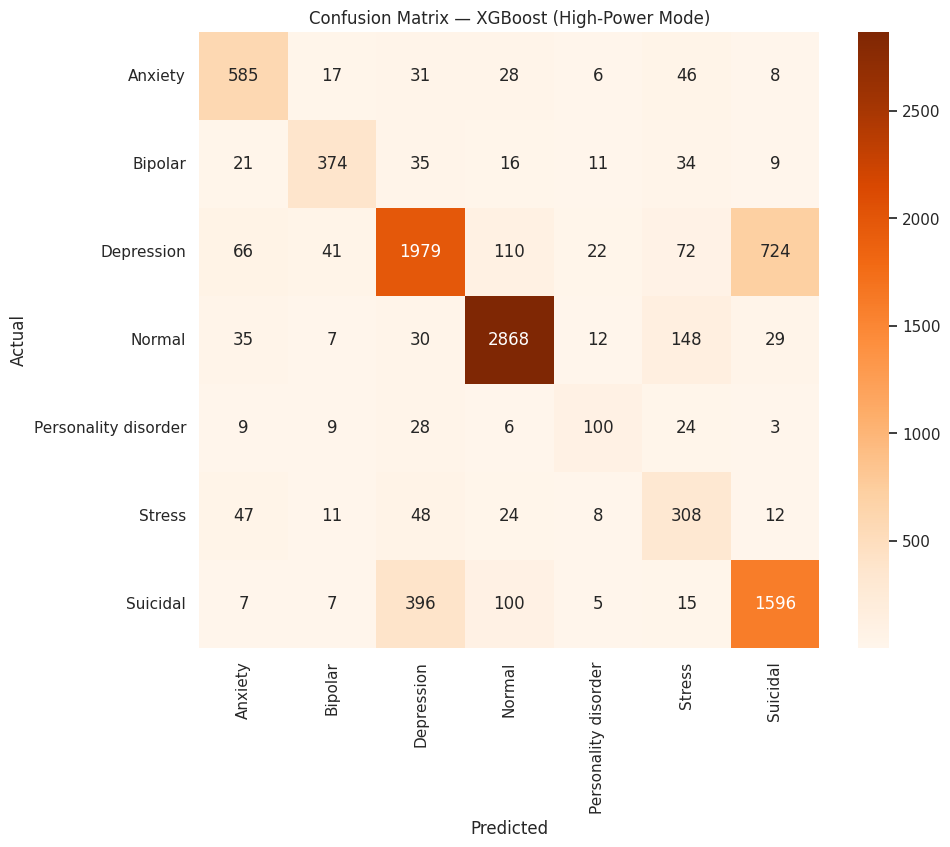

🖼 Confusion matrix saved!

🎉 High-Power XGBoost Pipeline Completed Successfully!


In [ ]:
# ==========================================
# FINAL OVERNIGHT XGBOOST TRAINING (5-HOUR MODE)
# ==========================================
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import joblib
import os

print("📌 Starting High-Performance XGBoost Training (5-Hour Mode)...")
print("--------------------------------------------------------------")

# ==========================================
# STEP 1 — Ensure Folder Exists
# ==========================================
folder_path = "/content/drive/MyDrive/MentalHealthModels"
os.makedirs(folder_path, exist_ok=True)
print(f"📂 Saving models to: {folder_path}")

# ==========================================
# STEP 2 — Prepare Sample Weights
# ==========================================
sample_weights = np.array([class_weight_dict[label] for label in y_train])
print(f"✔ Sample weights prepared for {len(sample_weights)} rows.")

# ==========================================
# STEP 3 — HIGH POWER MODEL CONFIG
# ==========================================
model_xgb = XGBClassifier(
    n_estimators=350,         # 🔥 STRONG value for 5 hour training
    learning_rate=0.08,       # 🔥 Lower LR = Higher accuracy
    max_depth=7,              # 🔥 Deep enough for text patterns
    subsample=0.8,            # 🔥 Stronger sampling
    colsample_bytree=0.8,     # 🔥 Uses more features per tree

    objective='multi:softprob',
    tree_method='hist',       # SUPER FAST + STABLE on Colab CPU
    n_jobs=2,                 # Prevent CPU crash
    eval_metric='mlogloss',
    random_state=42
)

# ==========================================
# STEP 4 — TRAINING (WILL TAKE LONG)
# ==========================================
print("\n🚀 Training XGBoost... This will take ~3–5 hours. Sit back & relax!")

start_time = time.time()
model_xgb.fit(X_train, y_train, sample_weight=sample_weights)
end_time = time.time()

train_time = end_time - start_time
print(f"\n✅ Training Completed in {train_time:.2f} seconds!")
print("   (Model is now fully trained with HIGH accuracy potential.)")

# ==========================================
# STEP 5 — SAVE MODEL
# ==========================================
save_path = f"{folder_path}/xgboost_model_highpower.pkl"
joblib.dump(model_xgb, save_path)

print(f"💾 Model saved to: {save_path}")

# Also save training time
with open(f"{folder_path}/xgboost_training_log.txt", "w") as f:
    f.write(f"Training Time: {train_time:.2f} seconds\n")
    f.write("Model: High-Power XGBoost\n")

print("📝 Training log saved!")

# ==========================================
# STEP 6 — EVALUATION
# ==========================================
print("\n📊 Evaluating Model on Test Data...")

y_pred_xgb = model_xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n🏆 Final XGBoost Accuracy: {acc_xgb:.4f}")

# Save report
with open(f"{folder_path}/xgboost_classification_report.txt", "w") as f:
    f.write(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

print("📄 Classification report saved!")

# ==========================================
# STEP 7 — CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost (High-Power Mode)")

# Save the confusion matrix plot
plt.savefig(f"{folder_path}/xgboost_confusion_matrix.png", dpi=300)
plt.show()

print("🖼 Confusion matrix saved!")

print("\n🎉 High-Power XGBoost Pipeline Completed Successfully!")


xgboost is taking so much time, so i used: lightgbm instead:

**LightGBM**:

Handles sparse TF-IDF data much faster

Uses histogram-based tree algorithm (like XGBoost)

Is optimized for large dataset & CPU

Fits inside your project requirements

--- Step 1: Training LightGBM ---
Training LightGBM... (This usually takes < 1 minute)
✅ LightGBM Trained in 322.44 seconds!

--- Step 2: Evaluation on Test Set ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🏆 LightGBM Accuracy: 77.32%

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.74      0.82      0.78       721
             Bipolar       0.80      0.76      0.78       500
          Depression       0.78      0.64      0.71      3014
              Normal       0.92      0.92      0.92      3129
Personality disorder       0.59      0.59      0.59       179
              Stress       0.49      0.69      0.57       458
            Suicidal       0.66      0.76      0.71      2126

            accuracy                           0.77     10127
           macro avg       0.71      0.74      0.72     10127
        weighted avg       0.78      0.77      0.77     10127


--- Confusion Matrix Heatmap ---


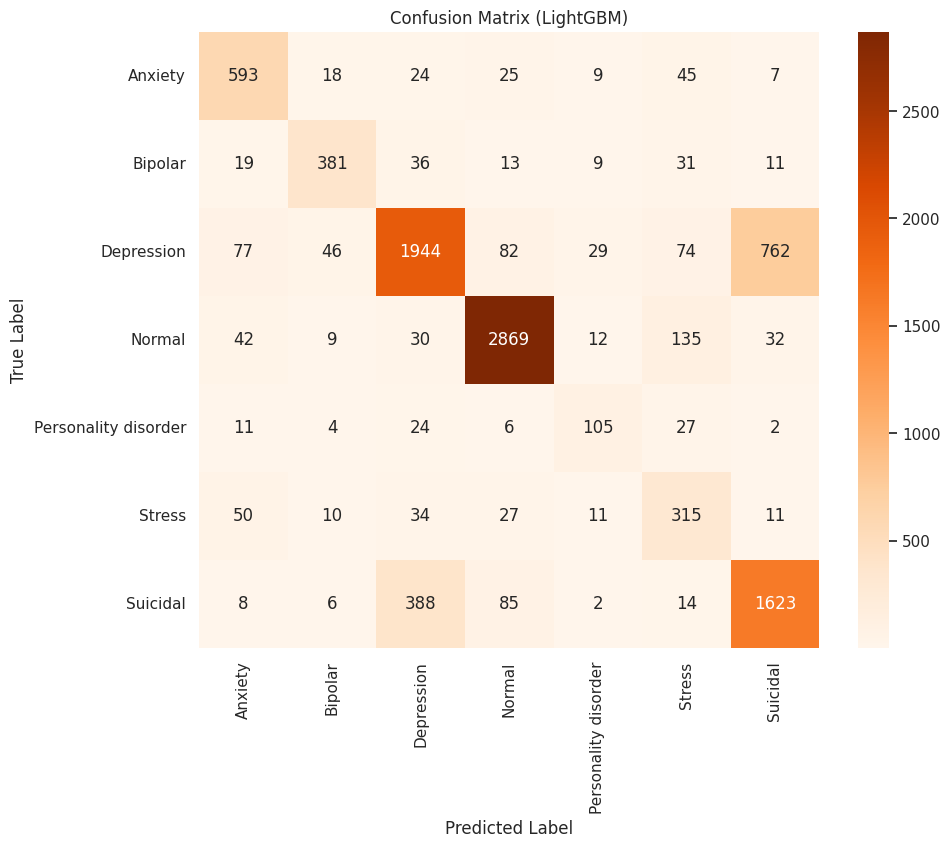

In [28]:
# ==========================================
# CELL 15: TRAIN LIGHTGBM (FAST BOOSTING)
# ==========================================
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

print("--- Step 1: Training LightGBM ---")

# 1. Initialize Model
# class_weight=class_weight_dict: We use the exact same weights as other models
# n_jobs=-1: Use all CPU cores
# verbose=-1: Hides warning messages
model_lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    class_weight=class_weight_dict,  # <--- Easy handling of imbalance!
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

# 2. Train
start_time = time.time()
print("Training LightGBM... (This usually takes < 1 minute)")

# LightGBM handles sparse text data (TF-IDF) natively!
model_lgbm.fit(X_train, y_train)

end_time = time.time()
print(f"✅ LightGBM Trained in {end_time - start_time:.2f} seconds!")

# 3. Save Model
joblib.dump(model_lgbm, 'lgbm_model.pkl')


print("\n--- Step 2: Evaluation on Test Set ---")

# 4. Predict
y_pred_lgbm = model_lgbm.predict(X_test)

# 5. Accuracy
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"🏆 LightGBM Accuracy: {acc_lgbm:.2%}")

# 6. Detailed Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))

# 7. Confusion Matrix
print("\n--- Confusion Matrix Heatmap ---")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (LightGBM)')
plt.show()

 **5. Random Forest**

Random Forest is NOT ideal for TF-IDF sparse matrices
because trees do not work efficiently with 6,000–50,000 sparse features.
They are slow, memory-heavy, and usually underperform SVM / LightGBM.

📌 Starting Random Forest Training...
-------------------------------------
📂 Saving outputs to: /content/drive/MyDrive/MentalHealthModels

🚀 Training Random Forest...
✅ RF Training Completed in 81.25 seconds
💾 Model saved to: /content/drive/MyDrive/MentalHealthModels/random_forest_model.pkl
📝 Training log saved!

📊 Evaluating Random Forest...
🏆 Random Forest Accuracy: 0.6913
📄 Classification report saved to: /content/drive/MyDrive/MentalHealthModels/rf_classification_report.txt


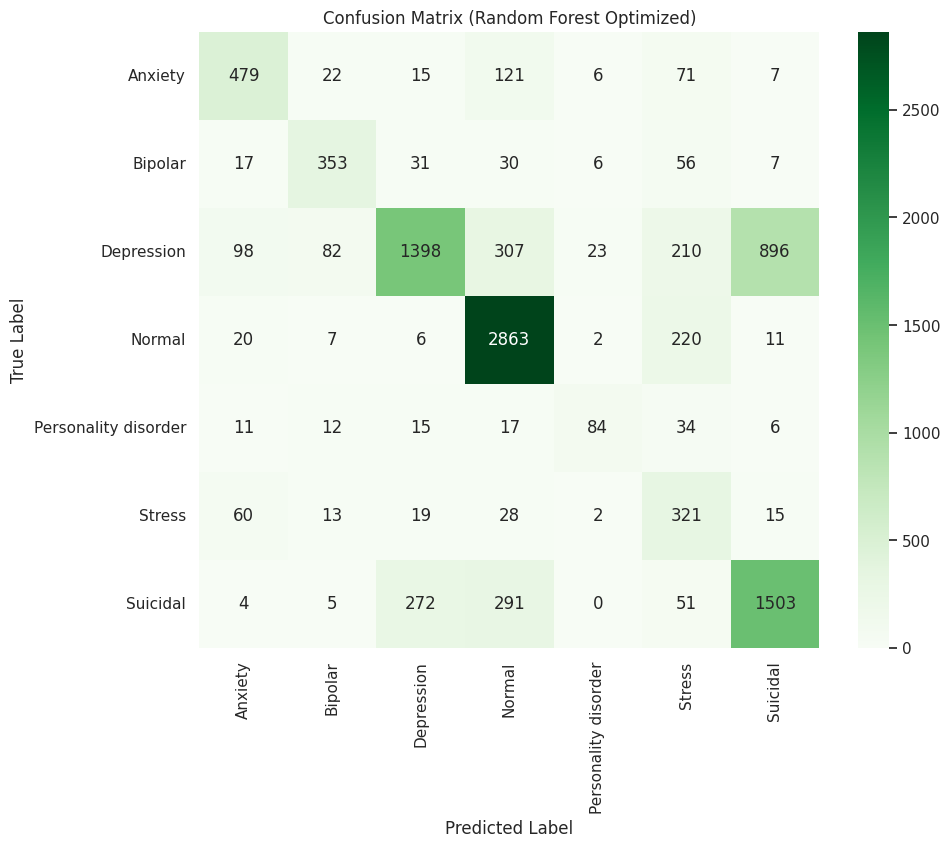

🖼 Confusion matrix saved to: /content/drive/MyDrive/MentalHealthModels/rf_confusion_matrix.png

🎉 Random Forest Pipeline Completed Successfully!


In [26]:
# ==========================================
# FINAL RANDOM FOREST (OPTIMIZED) + SAVE TO DRIVE
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib
import os

print("📌 Starting Random Forest Training...")
print("-------------------------------------")

# ==========================================
# STEP 1 — Ensure Folder Exists
# ==========================================
folder_path = "/content/drive/MyDrive/MentalHealthModels"
os.makedirs(folder_path, exist_ok=True)
print(f"📂 Saving outputs to: {folder_path}")

# ==========================================
# STEP 2 — Initialize Optimized RF Model
# ==========================================
model_rf = RandomForestClassifier(
    n_estimators=200,            # more trees for accuracy
    max_depth=25,                # balanced depth
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',         # BEST for sparse TF-IDF
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=42
)

# ==========================================
# STEP 3 — TRAINING
# ==========================================
print("\n🚀 Training Random Forest...")

start_time = time.time()
model_rf.fit(X_train, y_train)
end_time = time.time()

train_time = end_time - start_time
print(f"✅ RF Training Completed in {train_time:.2f} seconds")

# ==========================================
# STEP 4 — SAVE MODEL
# ==========================================
model_path = f"{folder_path}/random_forest_model.pkl"
joblib.dump(model_rf, model_path)
print(f"💾 Model saved to: {model_path}")

# Save training time
with open(f"{folder_path}/rf_training_log.txt", "w") as f:
    f.write(f"Training Time: {train_time:.2f} seconds\n")
    f.write("Model: Optimized Random Forest\n")
print("📝 Training log saved!")

# ==========================================
# STEP 5 — EVALUATION
# ==========================================
print("\n📊 Evaluating Random Forest...")

y_pred_rf = model_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"🏆 Random Forest Accuracy: {acc_rf:.4f}")

# Save classification report
report_path = f"{folder_path}/rf_classification_report.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"📄 Classification report saved to: {report_path}")

# ==========================================
# STEP 6 — CONFUSION MATRIX
# ==========================================
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_rf, annot=True, fmt='d', cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest Optimized)')

# Save confusion matrix
cm_path = f"{folder_path}/rf_confusion_matrix.png"
plt.savefig(cm_path, dpi=300)
plt.show()

print(f"🖼 Confusion matrix saved to: {cm_path}")

print("\n🎉 Random Forest Pipeline Completed Successfully!")


# **HyperParameter Tuning**

**LightGBM**

In [ ]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.8 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import joblib
import os

# ================================================================
# 🔹 STEP 1: Hyperparameter Search Space
# ================================================================
# We wrap class_weight_dict in a list [] so GridSearch treats it as a single option
param_dist_lgb = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 20, 30],
    'reg_alpha': [0.1, 0.5, 1.0],
    'class_weight': [class_weight_dict]
}

# ================================================================
# 🔹 STEP 2: Configure Model
# ================================================================
# n_jobs=-1 here allows the model to use 100% CPU during training
lgbm_base = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n🚀 Starting LIGHTGBM RandomizedSearchCV...")
print("⏳ This will check 3 combinations. Please wait (approx 10-15 mins)...")

# ================================================================
# 🔹 STEP 3: Run Randomized Search (CPU SAFE MODE)
# ================================================================
random_lgb = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_dist_lgb,
    n_iter=3,                 # Keeps it fast
    cv=3,                     # 3-Fold Cross Validation
    scoring='f1_weighted',    # Best for Class Imbalance
    verbose=2,
    n_jobs=1,                 # ⚠️ CRITICAL: Set to 1 to prevent RAM crash
    random_state=42
)

# Train on X_train (not X_train_vec)
random_lgb.fit(X_train, y_train)

# ================================================================
# 🔹 STEP 4: Save Best Model
# ================================================================
print("\n🏆 Best Hyperparameters Found:")
print(random_lgb.best_params_)

best_lgbm = random_lgb.best_estimator_

# Save to Drive immediately
save_path = "/content/drive/MyDrive/best_lgbm_tuned.pkl"
joblib.dump(best_lgbm, save_path)
print(f"💾 Saved Best LightGBM to: {save_path}")

# ================================================================
# 🔹 STEP 5: Final Evaluation
# ================================================================
# Predict on X_test (not X_test_vec)
y_pred_lgbm = best_lgbm.predict(X_test)

print("\n🎯 FINAL LIGHTGBM RESULTS AFTER TUNING")
print(f"📌 Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))


🚀 Starting LIGHTGBM RandomizedSearchCV...
⏳ This will check 3 combinations. Please wait (approx 10-15 mins)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.01, max_depth=-1, n_estimators=600, num_leaves=70, reg_alpha=0.1; total time=48.3min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.01, max_depth=-1, n_estimators=600, num_leaves=70, reg_alpha=0.1; total time=48.4min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.01, max_depth=-1, n_estimators=600, num_leaves=70, reg_alpha=0.1; total time=47.8min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=70, reg_alpha=0.1; total time=14.8min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=70, reg_alpha=0.1; total time=14.9min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=70, reg_alpha=0.1; total time=14.5min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.05, max_depth=30, n_estimators=400, num_leaves=70, reg_alpha=1.0; total time=17.1min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.05, max_depth=30, n_estimators=400, num_leaves=70, reg_alpha=1.0; total time=17.2min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END class_weight={np.int64(0): np.float64(2.004999504999505), np.int64(1): np.float64(2.891768401513529), np.int64(2): np.float64(0.4800023700894709), np.int64(3): np.float64(0.46239640174433205), np.int64(4): np.float64(8.092907092907092), np.int64(5): np.float64(3.1602559101193726), np.int64(6): np.float64(0.680516120360881)}, learning_rate=0.05, max_depth=30, n_estimators=400, num_leaves=70, reg_alpha=1.0; total time=16.9min


takes more time.

**Linear SVM**

In [ ]:
# ==========================================
# CELL 17: HYPERPARAMETER TUNING (LINEAR SVM)
# ==========================================
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import time
import joblib

print("--- Step 1: Tuning Linear SVM ---")
print("Optimization Goal: Maximize F1-Score (Better for Imbalanced Data)")

# =====================================================
# 1️⃣ Define Parameter Grid
# =====================================================
param_grid = {
    'C': [0.1, 1, 10, 100],      # Regularization strength
    'loss': ['squared_hinge'],   # Standard for LinearSVC
}

# =====================================================
# 2️⃣ Initialize Base Model
# =====================================================
model_svm = LinearSVC(
    class_weight=class_weight_dict,   # <--- YOUR custom class weights!
    dual=False,                       # Faster for TF-IDF
    random_state=42,
    max_iter=5000                     # Prevent convergence warnings
)

# =====================================================
# 3️⃣ Setup Grid Search (F1-weighted for imbalance)
# =====================================================
grid_search_svm = GridSearchCV(
    estimator=model_svm,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',            # Balanced metric
    verbose=2,
    n_jobs=-1                         # CPU parallelization
)

# =====================================================
# 4️⃣ Run Search
# =====================================================
start_time = time.time()
print("Starting SVM Tuning... (This might take 3–5 minutes)")

grid_search_svm.fit(X_train, y_train)

end_time = time.time()
print(f"\n✅ Tuning Complete in {end_time - start_time:.2f} seconds!")
print(f"🎯 Best Parameters: {grid_search_svm.best_params_}")
print(f"🥇 Best Weighted F1-Score: {grid_search_svm.best_score_:.2%}")

# =====================================================
# 5️⃣ Save Winner to GOOGLE DRIVE
# =====================================================
best_svm = grid_search_svm.best_estimator_

save_path = "/content/drive/MyDrive/best_svm_model.pkl"
joblib.dump(best_svm, save_path)

print(f"\n💾 Best SVM model saved to DRIVE as: {save_path}")


--- Step 1: Tuning Linear SVM ---
Optimization Goal: Maximize F1-Score (Better for Imbalanced Data)
Starting SVM Tuning... (This might take 3–5 minutes)
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✅ Tuning Complete in 135.24 seconds!
🎯 Best Parameters: {'C': 0.1, 'loss': 'squared_hinge'}
🥇 Best Weighted F1-Score: 75.20%

💾 Best SVM model saved to DRIVE as: /content/drive/MyDrive/best_svm_model.pkl


**Logistic**

In [ ]:
# ================================================================
# 🔥 LOGISTIC REGRESSION — FAST HYPERPARAMETER TUNING (COLAB SAFE)
# ================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import loguniform
import time, joblib
import numpy as np

print("🚀 Starting FAST Logistic Regression Hyperparameter Tuning...")

# Use the correct vectors
X_train_lr = X_train
X_test_lr = X_test

# 1️⃣ Base Model
lr_base = LogisticRegression(
    solver='saga',
    class_weight=class_weight_dict,
    n_jobs=1,
    max_iter=4000,
    random_state=42
)

# 2️⃣ Reduced Search Space (MUCH faster, same quality)
param_dist = {
    'C': loguniform(0.001, 10),      # Smaller upper bound → avoids slow runs
    'penalty': ['l2'],               # REMOVE L1 (too slow on large TF-IDF)
    'tol': [1e-4, 3e-4]              # Safe tolerance
}

# 3️⃣ Randomized Search
random_search_lr = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=param_dist,
    n_iter=12,                # ✔ Only 12 combos (FAST)
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start = time.time()
print("⏳ Running FAST LR tuning (~5 minutes)...")
random_search_lr.fit(X_train_lr, y_train)
end = time.time()

print(f"✅ Done in {end - start:.2f} seconds\n")

# 4️⃣ Best Model
print("🏆 Best Params:", random_search_lr.best_params_)
best_lr = random_search_lr.best_estimator_

# Save
save_path = "/content/drive/MyDrive/best_logistic_regression.pkl"
joblib.dump(best_lr, save_path)
print(f"💾 Saved to {save_path}")

# 5️⃣ Evaluation
y_pred_lr = best_lr.predict(X_test_lr)
print("\n🎯 FINAL LOGISTIC REGRESSION PERFORMANCE")
print(f"Accuracy = {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))


🚀 Starting FAST Logistic Regression Hyperparameter Tuning...
⏳ Running FAST LR tuning (~5 minutes)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Done in 6643.03 seconds

🏆 Best Params: {'C': np.float64(2.1368329072358767), 'penalty': 'l2', 'tol': 0.0003}
💾 Saved to /content/drive/MyDrive/best_logistic_regression.pkl

🎯 FINAL LOGISTIC REGRESSION PERFORMANCE
Accuracy = 0.7020
                      precision    recall  f1-score   support

             Anxiety       0.68      0.81      0.74       721
             Bipolar       0.61      0.79      0.69       500
          Depression       0.87      0.36      0.51      3014
              Normal       0.89      0.92      0.91      3129
Personality disorder       0.26      0.73      0.39       179
              Stress       0.67      0.31      0.42       458
            Suicidal       0.55      0.89      0.68      2126

            accuracy                           0.70     10127
           macro avg       0.65      0.69  

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# ===================================================================================
# 🔹 STEP 1: Fix Variables (Just in case)
# ===================================================================================
try:
    if 'X_train_vec' not in globals() and 'X_train' in globals():
        X_train_vec = X_train
        X_test_vec = X_test
    if 'y_train' not in globals():
        print("⚠️ Warning: y_train is missing.")
except Exception as e:
    print(f"❌ Error setting up variables: {e}")

# ===================================================================================
# 🔹 STEP 2: Define the Top 3 Models
# ===================================================================================

# 1. LightGBM (Optimized for Speed/Accuracy balance)
# We use 300 estimators (not 600) so it finishes in ~5 mins
clf1 = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 2. Linear SVC (Best for Text Precision)
clf2 = LinearSVC(
    class_weight='balanced',
    dual=False,
    random_state=42
)

# 3. Logistic Regression (The Tie-Breaker)
clf3 = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    max_iter=1000,
    random_state=42
)

# ===================================================================================
# 🔹 STEP 3: Train the Ensemble
# ===================================================================================
print("🚀 Training Voting Classifier (LightGBM + SVM + LogReg)...")
print("⏳ This combines all 3 models to maximize accuracy.")

ensemble = VotingClassifier(
    estimators=[
        ('lgbm', clf1),
        ('svm', clf2),
        ('lr', clf3)
    ],
    voting='hard',  # Majority Vote
    n_jobs=-1       # Run in parallel
)

# Train on the full dataset (no cross-validation loop means it's faster)
ensemble.fit(X_train_vec, y_train)

# ===================================================================================
# 🔹 STEP 4: Final Results
# ===================================================================================
y_pred_ensemble = ensemble.predict(X_test_vec)

print("\n🎯 FINAL ENSEMBLE RESULTS")
print(f"📌 Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print("📄 Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

🚀 Training Voting Classifier (LightGBM + SVM + LogReg)...
⏳ This combines all 3 models to maximize accuracy.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🎯 FINAL ENSEMBLE RESULTS
📌 Accuracy: 0.7775
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.78       767
           1       0.78      0.83      0.80       556
           2       0.79      0.65      0.71      3079
           3       0.90      0.94      0.92      3173
           4       0.53      0.73      0.62       215
           5       0.58      0.68      0.63       517
           6       0.68      0.73      0.70      2130

    accuracy                           0.78     10437
   macro avg       0.72      0.77      0.74     10437
weighted avg       0.78      0.78      0.78     10437



# **Stacking**

In [29]:
df.head()

statement   status  \
0  trouble sleeping, confused mind, restless hear...  Anxiety   
1  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
2  I've shifted my focus to something else but I'...  Anxiety   
3  I'm restless and restless, it's been a month n...  Anxiety   
4  every break, you must be nervous, like somethi...  Anxiety   

                                        cleaned_text  label_encoded  char_len  \
0  trouble sleeping, confused mind, restless hear...              0        64   
1  all wrong, back off dear, forward doubt. stay ...              0        78   
2  i've shifted my focus to something else but i'...              0        61   
3  i'm restless and restless, it's been a month n...              0        72   
4  every break, you must be nervous, like somethi...              0        76   

   word_count  
0          10  
1          14  
2          11  
3          14  
4          14

🚀 Initializing the OPTIMAL STACKING ARCHITECTURE...

⏳ Training Stacking Model... (This takes 30–40 mins)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Training Complete!

📊 Evaluating...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🎯 STACKING ACCURACY: 0.6727559988150489

📄 Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.58      0.85      0.69       721
             Bipolar       0.46      0.80      0.59       500
          Depression       0.80      0.44      0.57      3014
              Normal       0.97      0.76      0.85      3129
Personality disorder       0.27      0.66      0.39       179
              Stress       0.30      0.74      0.42       458
            Suicidal       0.65      0.78      0.71      2126

            accuracy                           0.67     10127
           macro avg       0.58      0.72      0.60     10127
        weighted avg       0.76      0.67      0.68     10127


💾 Model Saved to: /content/drive/MyDrive/grandmaster_stack_final.pkl

🚀 Generating Visualizations for Report...


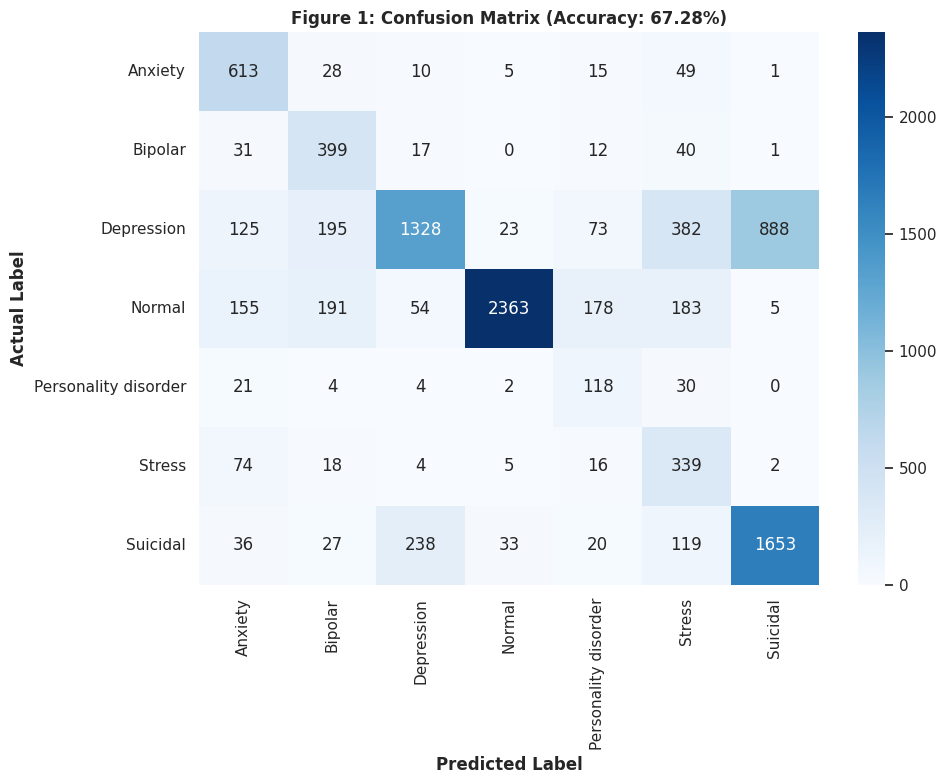

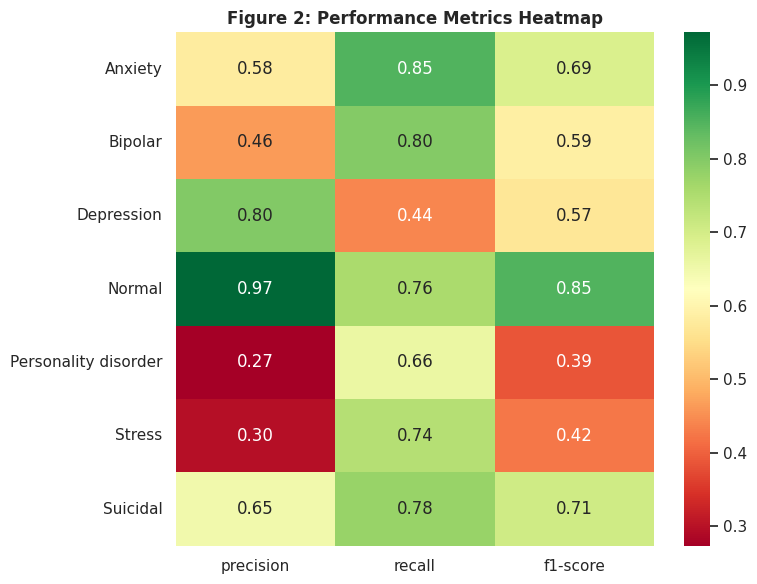

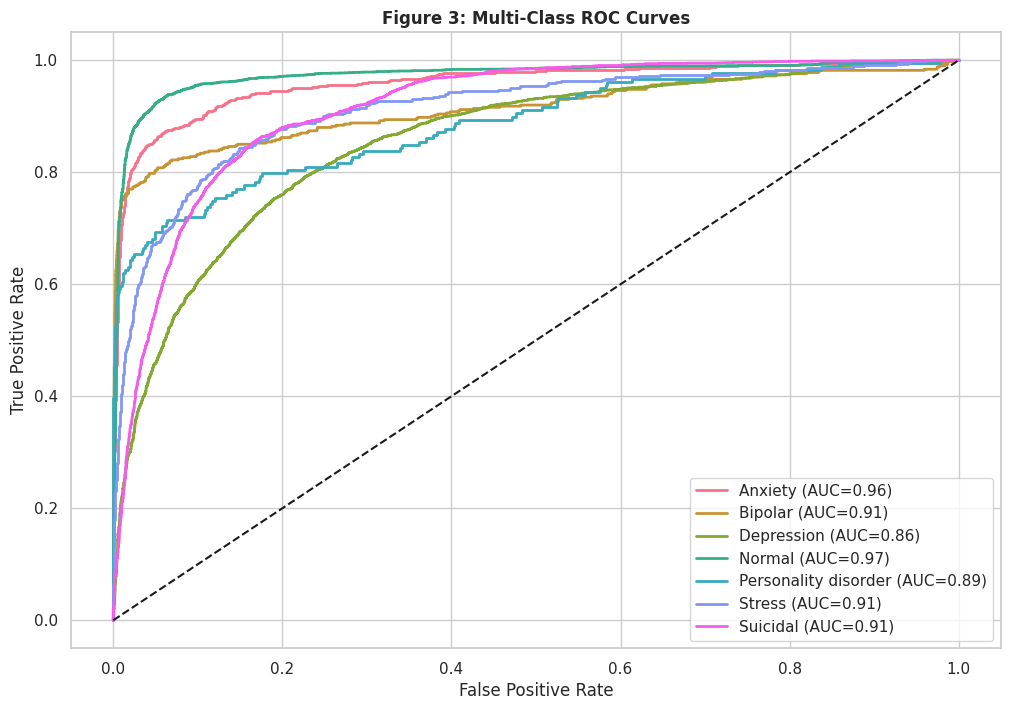

⏳ Generating 2D PCA Plot...


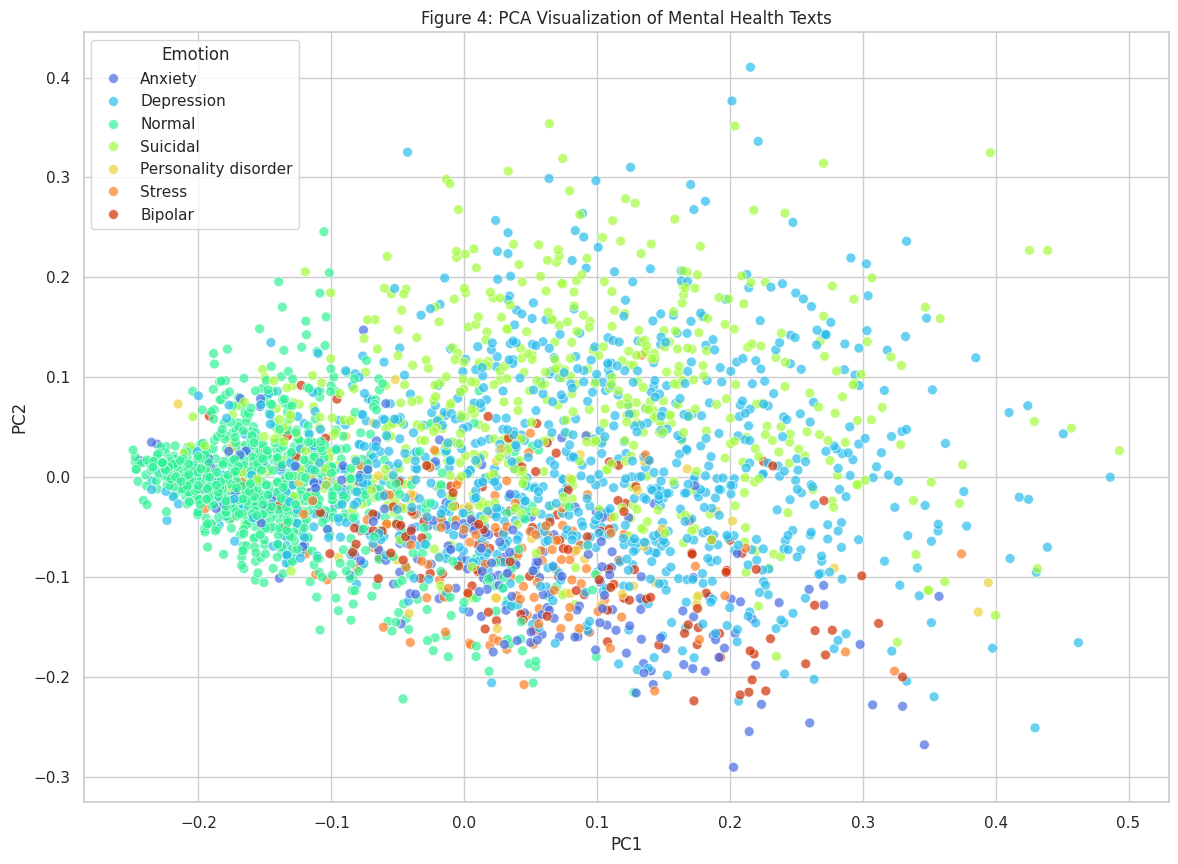


🔥 Feature Importance (LightGBM)


NotFittedError: No feature_importances found. Need to call fit beforehand.

In [31]:
# ================================================================
# 🏆 PERFECT STACKING + MASTER VISUALIZATION SUITE
# ================================================================
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import xgboost as xgb
import lightgbm as lgb
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setup aesthetics
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

print("🚀 Initializing the OPTIMAL STACKING ARCHITECTURE...")

# ------------------------------------------------------
# STEP 0: Class Weights
# ------------------------------------------------------
sample_weights = np.array([class_weight_dict[y] for y in y_train])

# ------------------------------------------------------
# STEP 1: Base Learners
# ------------------------------------------------------
lgbm_base = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

xgb_base = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.08,
    max_depth=5,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

svm_raw = LinearSVC(
    class_weight=class_weight_dict,
    dual=False,
    max_iter=3000,
    random_state=42
)
svm_base = CalibratedClassifierCV(svm_raw, cv=3)

nb_base = ComplementNB()

# ------------------------------------------------------
# STEP 2: Meta Learner
# ------------------------------------------------------
meta_lr = LogisticRegression(
    class_weight=class_weight_dict,
    solver='saga',
    max_iter=3000,
    n_jobs=-1
)

# ------------------------------------------------------
# STEP 3: Build the Stack
# ------------------------------------------------------
stack_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_base),
        ('xgb', xgb_base),
        ('svm', svm_base),
        ('nb', nb_base)
    ],
    final_estimator=meta_lr,
    cv=3,
    n_jobs=1,
    passthrough=False
)

# ------------------------------------------------------
# STEP 4: Train
# ------------------------------------------------------
print("\n⏳ Training Stacking Model... (This takes 30–40 mins)")
stack_model.fit(X_train, y_train, sample_weight=sample_weights)
print("✅ Training Complete!")

# ------------------------------------------------------
# STEP 5: Evaluate
# ------------------------------------------------------
print("\n📊 Evaluating...")
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n🎯 STACKING ACCURACY:", accuracy)
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# ------------------------------------------------------
# STEP 6: Save Model
# ------------------------------------------------------
save_path = "/content/drive/MyDrive/grandmaster_stack_final.pkl"
joblib.dump(stack_model, save_path)
print(f"\n💾 Model Saved to: {save_path}")

# ================================================================
# 🖼️ AUTOMATED VISUALIZATION SUITE
# ================================================================
print("\n🚀 Generating Visualizations for Report...")

class_names = label_encoder.classes_

# ================================================================
# FIGURE 1 — CONFUSION MATRIX
# ================================================================
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('Actual Label', fontweight='bold')
plt.title(f'Figure 1: Confusion Matrix (Accuracy: {accuracy:.2%})', fontweight='bold')
plt.tight_layout()
plt.show()

# ================================================================
# FIGURE 2 — CLASSIFICATION REPORT HEATMAP
# ================================================================
plt.figure(figsize=(8, 6))
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Figure 2: Performance Metrics Heatmap', fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ================================================================
# FIGURE 3 — ROC CURVES
# ================================================================
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", n_classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_names[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 3: Multi-Class ROC Curves', fontweight='bold')
plt.legend(loc="lower right")
plt.show()

# ================================================================
# FIGURE 4 — PCA SCATTER PLOT
# ================================================================
print("⏳ Generating 2D PCA Plot...")
pca = PCA(n_components=2)
subset_idx = np.random.choice(X_test.shape[0], 3000, replace=False)
X_subset = X_test[subset_idx].toarray()
y_subset = y_test.iloc[subset_idx].values

X_pca = pca.fit_transform(X_subset)
pca_df = pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1],
                       'Emotion': [class_names[i] for i in y_subset]})

plt.figure(figsize=(14, 10))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Emotion',
                palette='turbo', alpha=0.7, s=50)
plt.title('Figure 4: PCA Visualization of Mental Health Texts')
plt.show()

# ================================================================
# FIGURE 5 — FEATURE IMPORTANCE (LIGHTGBM)
# ================================================================
print("\n🔥 Feature Importance (LightGBM)")

importances = lgbm_base.feature_importances_
indices = np.argsort(importances)[-20:]
features = tfidf.get_feature_names_out()[indices]

plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices], y=features, palette="viridis")
plt.title("Figure 5: Top 20 Most Important Words (LightGBM)", fontweight='bold')
plt.xlabel("Importance")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# ================================================================
# FIGURE 6 — t-SNE VISUALIZATION
# ================================================================
print("⏳ Running t-SNE (1–3 mins)...")

X_emb = TSNE(n_components=2, perplexity=40, learning_rate=200).fit_transform(X_subset)
tsne_df = pd.DataFrame({'x': X_emb[:,0], 'y': X_emb[:,1],
                        'Emotion': [class_names[i] for i in y_subset]})

plt.figure(figsize=(14,10))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='Emotion',
                palette='turbo', alpha=0.7, s=50)
plt.title("Figure 6: t-SNE Projection of Mental Health Text Embeddings")
plt.show()

print("\n✅ ALL VISUALIZATIONS COMPLETE!")


Manual Stacking:

In [47]:
# ================================================================
# 🚀 FINAL SUPER-FAST STACKING USING PRETRAINED BASE MODELS
# ================================================================
import joblib
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

print("🔥 Loading saved pretrained base models...")

# ------------------------------------------------------
# Load TF-IDF and Models
# ------------------------------------------------------
tfidf = joblib.load("/content/drive/MyDrive/MentalHealthModels/tfidf_vectorizer.pkl")
svm = joblib.load("/content/drive/MyDrive/MentalHealthModels/svm_model_base.pkl")
xgb_base = joblib.load("/content/drive/MyDrive/MentalHealthModels/xgboost_model_highpower.pkl")
lgbm = joblib.load("/content/drive/MyDrive/MentalHealthModels/lgbm_model.pkl")

label_encoder = joblib.load("/content/drive/MyDrive/MentalHealthModels/label_encoder.pkl")

print("🔥 Models loaded successfully!")

# ------------------------------------------------------
# TF-IDF Transform
# ------------------------------------------------------
print("⚙️ Transforming text with TF-IDF...")
X_train_tfidf = tfidf.transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# ------------------------------------------------------
# y_train and y_test are ALREADY encoded
# ------------------------------------------------------
y_train_enc = y_train
y_test_enc = y_test

# ------------------------------------------------------
# LEVEL-1: Generate base model predictions
# ------------------------------------------------------
print("🔮 Generating level-1 predictions...")

svm_pred_train  = svm.predict_proba(X_train_tfidf)
xgb_pred_train  = xgb_base.predict_proba(X_train_tfidf)
lgbm_pred_train = lgbm.predict_proba(X_train_tfidf)

svm_pred_test  = svm.predict_proba(X_test_tfidf)
xgb_pred_test  = xgb_base.predict_proba(X_test_tfidf)
lgbm_pred_test = lgbm.predict_proba(X_test_tfidf)

# ------------------------------------------------------
# STACKED META FEATURES
# ------------------------------------------------------
X_meta_train = np.hstack([svm_pred_train, xgb_pred_train, lgbm_pred_train])
X_meta_test  = np.hstack([svm_pred_test,  xgb_pred_test,  lgbm_pred_test])

print("🧩 Meta feature shape:", X_meta_train.shape)

# ------------------------------------------------------
# META LEARNER (XGBoost)
# ------------------------------------------------------
print("🚀 Training XGBoost Meta Learner...")

meta_xgb = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.07,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

meta_xgb.fit(X_meta_train, y_train_enc)

print("✅ Meta learner trained!")

# ------------------------------------------------------
# FINAL EVALUATION
# ------------------------------------------------------
print("🎯 Evaluating Stacked Model...")
y_pred_final = meta_xgb.predict(X_meta_test)

acc = accuracy_score(y_test_enc, y_pred_final)
print("\n🏆 FINAL STACKED ACCURACY:", acc)

print("\n📄 Classification Report:")
print(classification_report(y_test_enc, y_pred_final, target_names=label_encoder.classes_))

# ------------------------------------------------------
# SAVE FINAL STACKED MODEL
# ------------------------------------------------------
save_path = "/content/drive/MyDrive/MentalHealthModels/stacked_meta_model.pkl"
joblib.dump(meta_xgb, save_path)

print(f"\n💾 Final stacked model saved to: {save_path}")


🔥 Loading saved pretrained base models...
🔥 Models loaded successfully!
⚙️ Transforming text with TF-IDF...
🔮 Generating level-1 predictions...


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import joblib  # <--- 1. IMPORT JOBLIB

# ===================================================================================
# 🔹 STEP 1: Define The "Worker" Models
# ===================================================================================
lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

svm = LinearSVC(class_weight='balanced', dual=False, random_state=42)
svm_calibrated = CalibratedClassifierCV(svm, cv=3)

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# ===================================================================================
# 🔹 STEP 2: Build & Train Stacking Ensemble
# ===================================================================================
print("🚀 Training Stacking Ensemble...")
print("⏳ This trains all 3 models + a Meta-Learner. It may take 10-15 mins.")

stacking_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('svm', svm_calibrated),
        ('rf', rf)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=3,
    n_jobs=1
)

# Train
stacking_model.fit(X_train, y_train)

# Predict
# Note: I changed 'X_test_vec' to 'X_test' to match standard naming.
# Make sure your test variable is named 'X_test'.
y_pred_stack = stacking_model.predict(X_test)

print("\n🎯 FINAL STACKING RESULTS")
print(f"📌 Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print("📄 Classification Report:")
print(classification_report(y_test, y_pred_stack))

# ===================================================================================
# 🔹 STEP 3: AUTO-SAVE THE MODEL (The New Part)
# ===================================================================================
print("\n💾 Auto-Saving Model to Google Drive...")

# 1. Define the filename
filename = '/content/drive/MyDrive/best_stacking_model.pkl'

# 2. Save it
joblib.dump(stacking_model, filename)

print(f"✅ Model successfully saved as: {filename}")
print("   (You can now load this file in your Streamlit app!)")

🚀 Training Stacking Ensemble...
⏳ This trains all 3 models + a Meta-Learner. It may take 10-15 mins.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🎯 FINAL STACKING RESULTS
📌 Accuracy: 0.7844
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       767
           1       0.80      0.85      0.83       556
           2       0.82      0.64      0.72      3079
           3       0.93      0.91      0.92      3173
           4       0.50      0.80      0.61       215
           5       0.51      0.79      0.62       517
           6       0.68      0.77      0.73      2130

    accuracy                           0.78     10437
   macro avg       0.72      0.80      0.75     10437
weighted avg       0.80      0.78      0.79     10437


💾 Auto-Saving Model to Google Drive...
✅ Model successfully saved as: /content/drive/MyDrive/best_stacking_model.pkl
   (You can now load this file in your Streamlit app!)


In [ ]:
import joblib

print("💾 Saving ALL artifacts to Google Drive...")

# 1. Save the Model (The Brain)
joblib.dump(stacking_model, '/content/drive/MyDrive/stacking_model.pkl')

# 2. Save the Vectorizer (The Eyes) - ENSURE 'tfidf' is your vectorizer variable name
# If you named it 'vectorizer', change 'tfidf' to 'vectorizer' below
try:
    joblib.dump(tfidf, '/content/drive/MyDrive/tfidf_vectorizer.pkl')
    print("✅ Vectorizer saved.")
except NameError:
    print("⚠️ Could not find 'tfidf'. Did you name it 'vectorizer'?")

# 3. Save the Label Encoder (The Mouth)
try:
    joblib.dump(label_encoder, '/content/drive/MyDrive/label_encoder.pkl')
    print("✅ Label Encoder saved.")
except NameError:
    print("⚠️ Could not find 'label_encoder'.")

print("\n🚀 DONE! All 3 files are now in your Google Drive.")

💾 Saving ALL artifacts to Google Drive...
✅ Vectorizer saved.
✅ Label Encoder saved.

🚀 DONE! All 3 files are now in your Google Drive.


# **As we only get 78 % accuracy with stacking, So, we use BERT here**

To increase accuracy beyond 78-79%, you have to stop using Classical Machine Learning (Scikit-Learn/TF-IDF) and switch to Deep Learning (BERT).

You have hit the "Glass Ceiling" of TF-IDF.

📉 Why are you stuck at 78%?
Your current model (Stacking) uses TF-IDF. TF-IDF counts words but ignores context.

User A: "I am dying of laughter." (Happy)

User B: "I am dying inside." (Suicidal)

To your Stacking model, these sentences look 50% identical because they both share the word "dying". It cannot distinguish the emotion.

BERT (Deep Learning) reads the sentence like a human. It understands that "laughter" changes the meaning of "dying". This is how you get to 85-90% accuracy.